In [1]:
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from Code.utils.mean_value_regressor import mean_value_regressor
from Code.utils.evaluation_utils import get_metrics, get_cross_validate_scorer
from sklearn.linear_model import LinearRegression
from Code.utils.positive_values_model_wrapper import positive_values_model_wrapper
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# 1. Učitavanje i kratak pregled dostupnih podataka

In [2]:
DATA_DIR = "../../Data"
FILE_NAME = "vehicles.csv"

original_df = pd.read_csv(os.path.join(DATA_DIR, FILE_NAME))

Za početak možemo pogledati nekoliko primjera ulaznih podataka iz našeg dataseta

In [3]:
original_df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


Za sažete informacije o svakom od stupaca možemo iskoristiti df.info() naredbu

In [4]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

Vidimo da raspolažemo s ukupno 25 značajki, odnosno 22 ako zanemarimo značaju URL, region URL i image URL (iako, i te značajke se mogu pokazati korisne, pogotovo u slučaju nepotpunih podataka u drugim stupcima, jer često u sebi sadrže npr. naziv vozila ili proizvođača). Od te 22 "prave" značajke, 5 su numeričke (cijena, godina proizvodnje, vrijednost odometra te geografska širina i duljina), 13 su kategoričke varijable, 3 su stringovi proizvoljnog sadržaja (opis, VIN te datum kreiranja oglasa) dok je jedna značajka - county, greškom dodan i ne sadrži nikakve vrijednosti. Na prvi pogled također možemo primijetiti veliki broj nepostojećih vrijednosti u nekim od stupaca/značajki, što nam već sad može ukazati na potrebu za detaljnijom analizom podataka i pažljivim odabirom korištenih značajki.

In [5]:
numerical = ['price', 'year', 'odometer', 'lat', 'long']
categorical = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
               'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']

# 2. Explaratory data analysis


## 2.1. Analiza i čišćenje numeričkih značajki

Osnovnu analizu (numeričkih) značajki možemo dobit Pandasovom funkcijom df.describe(). Prije toga samo uklanjamo stupac "county" kako ne bi bio uključen u analizu. Također uklanjamo i stupac ID, pošto nam ne donosi nikakve korisne informacije.

In [6]:
original_df = original_df.drop('county', axis=1)
original_df = original_df.drop('id', axis=1)
original_df.describe()

,price,year,odometer,lat,long
count,4.268800e+05,425675.000000,4.224800e+05,420331.000000,420331.000000
mean,7.519903e+04,2011.235191,9.804333e+04,38.493940,-94.748599
std,1.218228e+07,9.452120,2.138815e+05,5.841533,18.365462
min,0.000000e+00,1900.000000,0.000000e+00,-84.122245,-159.827728
25%,5.900000e+03,2008.000000,3.770400e+04,34.601900,-111.939847
50%,1.395000e+04,2013.000000,8.554800e+04,39.150100,-88.432600
75%,2.648575e+04,2017.000000,1.335425e+05,42.398900,-80.832039
max,3.736929e+09,2022.000000,1.000000e+07,82.390818,173.885502


Iz navedenih podataka možemo primijetiti outliere u stupcima price i odometar -> najniža cijena je navedena kao 0$, dok najviša cijena prelazi 3.73 milijarde dolara. Slična situacija je i za stupac odometar, gdje je navodna najveća vrijednost 10 milijuna milja -> ukoliko bi se taj podatak pokazao istinitim, broj prijeđenih kilometara tog automobila srušio bi dosadašnji <a href="https://www.autoweek.com/news/trucks/a42108537/cars-with-the-longest-life-toyota-sequoia-iseecars-study/#:~:text=The%20highest%20mileage%20car%20on,and%20the%20Nissan%20Leaf%2098%2C081.">rekord</a> za više od 7 milijuna milja. Stoga, prije daljnje analize i vizualizacije podataka, ukloniti ću ove očite outliere kako ne bi predstavljali problem u daljnoj analizi.


In [7]:
PRICE_UPPER_BOUNDARY = 1e7
PRICE_LOWER_BOUNDARY = 100

ODOMETER_UPPER_BOUNDARY = 1e6

no_above_upper_price = original_df[original_df.price > PRICE_UPPER_BOUNDARY].shape[0]
no_below_lower_price = original_df[original_df.price < PRICE_LOWER_BOUNDARY].shape[0]


print(f"Number of examples above upper price boundary: {no_above_upper_price}")
print(f"NUmber of examples below lower price boundary: {no_below_lower_price}")

no_above_odometer_upper = original_df[original_df.odometer > ODOMETER_UPPER_BOUNDARY].shape[0]
print(f"Number of examples above odometer upper boundary: {no_above_odometer_upper}")


orignal_count = original_df.shape[0]

original_df = original_df[(original_df.price < PRICE_UPPER_BOUNDARY) & (original_df.price > PRICE_LOWER_BOUNDARY) & (original_df.odometer < ODOMETER_UPPER_BOUNDARY)]

new_count = original_df.shape[0]

print(f"Dropped a total of {orignal_count - new_count} examples")


Number of examples above upper price boundary: 30
NUmber of examples below lower price boundary: 36222
Number of examples above odometer upper boundary: 576
Dropped a total of 39205 examples




Kao granicu za vrijednost odometra postavio sam milijun milja, a kao granicu za cijenu 10 milijuna dolara, što bi trebalo pokriti sve razumne slučajeve. Automobile s cijenom većom od 10 milijuna dolara, ili rekordere koji su prešli više od milijuna milja ćemo u svakom slučaju teško pronaći na Craigslistu. Također sam izbacio sve automobile s cijenom manjom od 100 dolara, jer se u tim slučajevima često radi o ljudima koji namjerno stavljaju nerealno malenu cijenu kako bi se njihov oglas prikazao što većem broju ljudi.

Analizu podataka možemo započeti box-plotom značajki price i odometar, jer iako sam uklonio najveće outliere, uzorkovane najvjerojatnije pogreškama u podacima, neki prirodni(iji) outlieri će i dalje biti najizraženiji u ove dvije značajke. Kako bi ovi outlieri mogli utjecati na prikaz podataka a kasnije i na treniranje odabranih modela, bitno ih je biti svjestan. Pogledajmo prvo box-plot cijena rabljenih automobila

[Text(0.5, 1.0, 'Box plot of used car prices')]

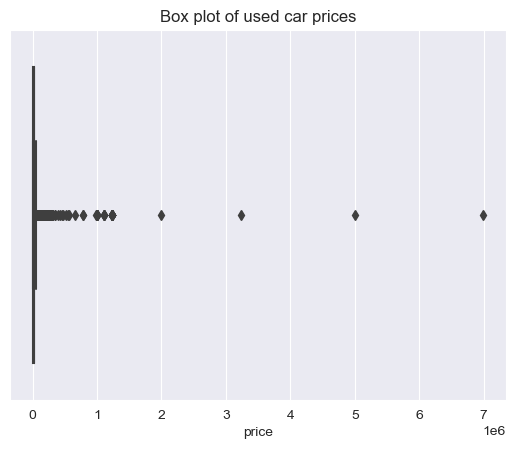

In [8]:
sns.boxplot(x=original_df['price']).set(title="Box plot of used car prices")

Iz dobivenog box-plota možemo primijetiti kako i dalje imamo popriličan broj outliera u našim podacima. Kako bi provjerili radi li se o ispravnim ili neispravnim podacima, pogledajmo nekoliko outliera, s cijenom iznad neke proizvoljne gornje granice, npr. 500,000$.

In [9]:
original_df[original_df['price'] > 0.5e6].head(n=50)

,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
26075,https://fresno.craigslist.org/cto/d/modesto-we...,fresno / madera,https://fresno.craigslist.org,1111111,2014.0,chevrolet,NaN,NaN,NaN,other,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00n0n_5kcw1GxZQM...,"WE WILL COME TO YOU OR YOU CAN COME TO US, CHE...",ca,37.674600,-121.011300,2021-04-30T12:20:06-0700
68935,https://ventura.craigslist.org/cto/d/camarillo...,ventura county,https://ventura.craigslist.org,2000000,2002.0,saturn,l-series l200 4dr sedan,good,4 cylinders,gas,...,fwd,mid-size,sedan,green,https://images.craigslist.org/00y0y_hw8QSdnerF...,No longer need runs and drives great. This ca...,ca,34.236498,-119.039074,2021-04-06T16:40:31-0700
79088,https://fortcollins.craigslist.org/cto/d/mason...,fort collins / north CO,https://fortcollins.craigslist.org,655000,2010.0,chrysler,town & country,good,6 cylinders,gas,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00d0d_1IXGGXaTY3...,Selling our 2010 Chrysler town and counrty Ti...,co,40.478853,-105.173998,2021-04-27T13:17:32-0600
83367,https://newlondon.craigslist.org/cto/d/sagapon...,eastern CT,https://newlondon.craigslist.org,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00S0S_k3A68PVXRC...,We come to you and give you an easy quick tran...,ct,40.930500,-72.270700,2021-04-11T13:49:50-0400
87052,https://newhaven.craigslist.org/cto/d/north-ha...,new haven,https://newhaven.craigslist.org,1000000,2019.0,NaN,Call for a free estimate,NaN,NaN,gas,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00G0G_itBGvZsauj...,done the day you want and in your own driveway...,ct,41.382200,-72.858500,2021-04-17T12:33:48-0400
91605,https://delaware.craigslist.org/cto/d/delaware...,delaware,https://delaware.craigslist.org,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00S0S_k3A68PVXRC...,We come to you and give you an easy quick tran...,de,39.572500,-75.595700,2021-04-19T09:55:42-0400
91807,https://delaware.craigslist.org/cto/d/delaware...,delaware,https://delaware.craigslist.org,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00S0S_k3A68PVXRC...,We come to you and give you an easy quick tran...,de,39.572500,-75.595700,2021-04-11T13:51:42-0400
95119,https://fortmyers.craigslist.org/col/ctd/d/nap...,ft myers / SW florida,https://fortmyers.craigslist.org,990000,2017.0,mercedes-benz,amg g 63,NaN,8 cylinders,gas,...,4wd,NaN,SUV,white,https://images.craigslist.org/00P0P_4xcfVqDGil...,2017 Mercedes-Benz AMG G 63 SUV2017 Mercedes-B...,fl,26.157900,-81.766548,2021-04-24T13:12:08-0400
105843,https://orlando.craigslist.org/ctd/d/orlando-d...,orlando,https://orlando.craigslist.org,6995495,2014.0,dodge,journey,NaN,4 cylinders,gas,...,fwd,NaN,SUV,NaN,https://images.craigslist.org/01010_d7c56qbQLs...,"2014 Dodge Journey SE Sport Utility 4D - $6,99...",fl,28.394900,-81.417900,2021-04-28T20:11:41-0400
106361,https://orlando.craigslist.org/ctd/d/orlando-2...,orlando,https://orlando.craigslist.org,516999,2016.0,NaN,Lambo Aventador SV Roadster,like new,12 cylinders,gas,...,4wd,full-size,convertible,white,https://images.craigslist.org/00n0n_eGPWhFc9Nn...,"Serious/ready buyers, please reach out via cal...",fl,28.463700,-81.394800,2021-04-26T17:40:47-0400


Vidimo kako se u većini slučajeva radi ili o "lažnim" oglasima (cilj oglasa je reklamirati npr. kompaniju za prodaju rabljenih automobila, a ne prodati auto), ili o oglasima u kojima je cijena neopravdana - npr. Ford F150 iz 2016 godine najvjerojatnije ne vrijedi 1,000,000 USD. Također primijećujem da se u velikoj većini slučajeva radi o namjerno unešenim krivim vrijednostima - česte su vrijednosti 123456, 1111111 ili 777777. Iako se među podacima može pronaći poneki ispravan podatak (npr. Lamborghini Aventador, koji zaista vrijedi 517,000$), većinu outliera čine nekvalitetni podaci, te ih je potrebno ukloniti.

Pošto nemam garanciju da su podaci raspoređeni po normalnoj distribuciji, odlučio sam se za metodu korištenjem IQR (Interquartile Range). Ideja ove metode je ukloniti sve outliere koji su za K*IQR iznad gornjeg kvartila, ili K * IQR iznad donjeg kvartila, gdje je K proizvoljan faktor. Kako sam već uklonio outliere iz donjeg raspona, ovom metodom ću ukloniti samo "gornje" outliere. Kao faktor K se često koriste vrijednosti 1.5 ili 3, ja sam odabrao konzervativniju vrijednost K = 3 kako ipak ne bi uklonio automobile koji su jednostavno više cijene.

Quartiles


0.25     7495.0
0.50    15500.0
0.75    27798.0
Name: price, dtype: float64

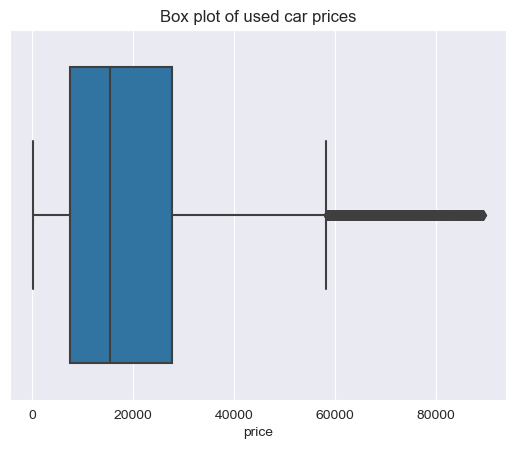

In [10]:
def remove_upper_outeliers(df, col_name, k = 3):
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    upper_limit = q3+k*iqr
    df_out = df.loc[(df[col_name] < upper_limit)]
    return df_out

def remove_lower_outliers(df, col_name, k = 3):
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    lower_limit = q1-k*iqr
    df_out = df.loc[(df[col_name] > lower_limit)]
    return df_out


original_df = remove_upper_outeliers(original_df, 'price', k=3)
sns.boxplot(x=original_df['price']).set(title="Box plot of used car prices")

print("Quartiles")
original_df['price'].quantile([0.25, 0.5, 0.75])

Vidimo da sada box-plot dijagram izgleda znatno "normalnije". Outlieri su i dalje prisutni, no manje ih je i njihove vrijednosti su manje nego prije.

Sada možemo pogledati i box-plot za vrijednosti odometra.

Quartiles


0.25     38189.0
0.50     87200.0
0.75    135497.0
Name: odometer, dtype: float64

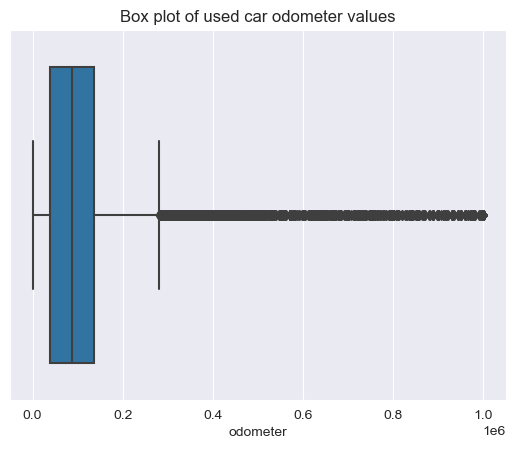

In [11]:
sns.boxplot(x=original_df['odometer']).set(title="Box plot of used car odometer values")
print("Quartiles")
original_df['odometer'].quantile([0.25, 0.5, 0.75])

Vidimo da ovaj box-plot izgleda relativno normalno - 75% vrijednosti nalazi se ispod 136,000 milja. Primijećujem i značajan broj outliera s vrijednostima iznad 250,000 milja. No, smatram da je to očekivano, jer uvijek će postojati određeni broj automobila koji zaista jesu prešli tolike udaljenosti. Za svaki slučaj, pogledajmo nekoliko primjera s visokom i niskom vrijednosti odometra.

In [12]:
original_df[original_df['odometer'] > 0.5e6].head(n=50)

,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
1536,https://bham.craigslist.org/ctd/d/cullman-sing...,birmingham,https://bham.craigslist.org,14900,2005.0,NaN,KW T800,NaN,NaN,diesel,...,NaN,NaN,NaN,white,https://images.craigslist.org/00O0O_7qASRuAop2...,"2005 KW T800 single axle day cabs, Cummins ISX...",al,34.209800,-86.752000,2021-04-09T10:16:20-0500
2781,https://huntsville.craigslist.org/cto/d/pisgah...,huntsville / decatur,https://huntsville.craigslist.org,23000,1967.0,chevrolet,c10 truck,good,8 cylinders,gas,...,rwd,full-size,truck,red,https://images.craigslist.org/00i0i_7u40y2wO2i...,1967 C10 Nice driver new 4 wheel disc master c...,al,34.680900,-85.847800,2021-04-29T19:27:09-0500
2820,https://huntsville.craigslist.org/cto/d/spring...,huntsville / decatur,https://huntsville.craigslist.org,1000,1973.0,toyota,NaN,NaN,NaN,other,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00Y0Y_9GCZJQLgyu...,Please feel free to get in touch about ANY old...,al,35.717300,-86.904800,2021-04-29T00:10:28-0500
4355,https://mobile.craigslist.org/cto/d/huntsville...,mobile,https://mobile.craigslist.org,5990,1995.0,volvo,coe semi w/18 feet frame,NaN,6 cylinders,diesel,...,rwd,full-size,truck,white,https://images.craigslist.org/00o0o_gGjycJyieW...,1995 Volvo White Gmc with 3176b Caterpillar an...,al,34.744800,-86.670400,2021-04-08T08:05:06-0500
5560,https://anchorage.craigslist.org/ctd/d/anchora...,anchorage / mat-su,https://anchorage.craigslist.org,4600,2006.0,ford,taurus se,NaN,NaN,gas,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00X0X_kOk7tGij6E...,"2006 FORD TAURUS SE, EXCELLENT CONDITION Locat...",ak,61.207780,-149.870853,2021-04-29T14:26:10-0800
5566,https://anchorage.craigslist.org/ctd/d/anchora...,anchorage / mat-su,https://anchorage.craigslist.org,6900,1999.0,ford,ranger,NaN,NaN,gas,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00D0D_6PV9zjvwmv...,"1999 FORD RANGER, EXCELLENT CONDITION, 4X4 Loc...",ak,61.207790,-149.870832,2021-04-29T14:19:11-0800
5567,https://anchorage.craigslist.org/ctd/d/anchora...,anchorage / mat-su,https://anchorage.craigslist.org,3500,1997.0,mercury,mountaineer,NaN,NaN,gas,...,NaN,NaN,NaN,white,https://images.craigslist.org/00000_x07HSmlhRS...,"1997 MERCURY MOUNTAINEER, EXCELLENT CONDITION,...",ak,61.207790,-149.870832,2021-04-29T14:14:58-0800
5583,https://anchorage.craigslist.org/cto/d/anchora...,anchorage / mat-su,https://anchorage.craigslist.org,2800,1988.0,chevrolet,rally,NaN,NaN,gas,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00F0F_2g4cNj0cgW...,"1988 Rally Van, runs great ... $2800 Includes ...",ak,61.211600,-149.876100,2021-04-29T13:16:49-0800
6110,https://anchorage.craigslist.org/cto/d/anchora...,anchorage / mat-su,https://anchorage.craigslist.org,2200,1987.0,ford,f150,NaN,NaN,gas,...,NaN,NaN,NaN,grey,https://images.craigslist.org/00q0q_2o7wmlBkm5...,1987 Ford F150 Pickup ..... $2200 runs excell...,ak,61.153500,-149.828900,2021-04-23T16:32:32-0800
8616,https://flagstaff.craigslist.org/ctd/d/pinetop...,flagstaff / sedona,https://flagstaff.craigslist.org,1895,2000.0,chevrolet,venture,good,6 cylinders,gas,...,fwd,mid-size,mini-van,grey,https://images.craigslist.org/00101_jxyDlm3NOV...,ACCUSHINE AUTO SALES 1827 E. WHITE MTN. BLVD. ...,az,34.117500,-109.919700,2021-04-29T11:39:29-0700


In [13]:
original_df[original_df['odometer'] < 100].head(n=50)

,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
84,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,28990,2020.0,buick,encore gx essence sport,good,NaN,gas,...,NaN,NaN,other,white,https://images.craigslist.org/00a0a_7ojpNN3PG0...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2021-04-22T09:01:26-0500
158,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,52990,2020.0,jaguar,e-pace p300 r-dynamic se,good,NaN,gas,...,NaN,NaN,other,white,https://images.craigslist.org/00p0p_4qfF2tImVZ...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2021-04-06T08:24:50-0500
414,https://bham.craigslist.org/cto/d/ormond-beach...,birmingham,https://bham.craigslist.org,39900,2015.0,lincoln,NaN,NaN,NaN,gas,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00i0i_8sGrGiSVN5...,beautiful 2015 Lincoln MKS personal limousine ...,al,29.283300,-81.088200,2021-04-29T18:26:24-0500
694,https://bham.craigslist.org/ctd/d/alabaster-20...,birmingham,https://bham.craigslist.org,3980,2013.0,kia,rio,NaN,4 cylinders,gas,...,fwd,NaN,sedan,white,https://images.craigslist.org/00E0E_3SWFRnofnR...,"2013 *Kia* *Rio* 4dr Sedan Manual LX - $3,980C...",al,33.209789,-86.783493,2021-04-24T13:50:11-0500
822,https://bham.craigslist.org/ctd/d/south-amboy-...,birmingham,https://bham.craigslist.org,34990,2018.0,NaN,Isuzu NPR HD GAS CREW,good,8 cylinders,gas,...,rwd,NaN,NaN,white,https://images.craigslist.org/00V0V_jEIScPbp8o...,"2018 Isuzu NPR HD GAS CREW CAB & CHASSIS,, CRE...",al,40.468785,-74.281707,2021-04-23T11:02:54-0500
1323,https://bham.craigslist.org/cto/d/birmingham-w...,birmingham,https://bham.craigslist.org,44650,1942.0,NaN,WILLYS MB,NaN,NaN,gas,...,NaN,NaN,convertible,NaN,https://images.craigslist.org/00s0s_850reJiYhX...,FOR SALE IS A FULLY RESTORED 1942 WW2 MILITARY...,al,33.445900,-86.750200,2021-04-14T09:32:24-0500
1594,https://bham.craigslist.org/ctd/d/new-castle-2...,birmingham,https://bham.craigslist.org,36495,2017.0,rover,discovery sport,NaN,4 cylinders,gas,...,4wd,NaN,SUV,white,https://images.craigslist.org/00R0R_5oCxaRxQTE...,2017 *Land Rover* *Discovery Sport* HSE AWD SU...,al,33.669601,-86.817617,2021-04-08T10:11:19-0500
1720,https://bham.craigslist.org/ctd/d/tuscaloosa-2...,birmingham,https://bham.craigslist.org,10477,2009.0,chevrolet,colorado,NaN,NaN,gas,...,NaN,NaN,NaN,black,https://images.craigslist.org/00404_jPWmUx686Z...,Contemporary Automotive address: 3427 Skyla...,al,33.168322,-87.491902,2021-04-06T08:46:53-0500
1802,https://bham.craigslist.org/ctd/d/birmingham-2...,birmingham,https://bham.craigslist.org,52990,2020.0,jaguar,e-pace p300 r-dynamic se,good,NaN,gas,...,NaN,NaN,other,white,https://images.craigslist.org/00p0p_4qfF2tImVZ...,Carvana is the safer way to buy a car During t...,al,33.520000,-86.790000,2021-04-04T11:11:20-0500
1804,https://bham.craigslist.org/ctd/d/alabaster-20...,birmingham,https://bham.craigslist.org,11980,2013.0,infiniti,g37 sedan,NaN,6 cylinders,gas,...,rwd,NaN,sedan,silver,https://images.craigslist.org/00P0P_kom3wltPPJ...,2013 *INFINITI* *G37 Sedan* 4dr Journey RWD - ...,al,33.209789,-86.783493,2021-04-04T11:10:27-0500



Kratkim istraživanjem outliera, zaključujem da, za visoke vrijednosti odometra, ljudi često stavljaju vrijednosti poput 999,999, koje su očito lažne. Postoje i ispravne vrijednosti, no neispravne ih na prvi pogled nadmašuju. Što se tiče outliera s malim vrijednostima odometra, ne pronalazim neke pretjerano sumnjive primjere - većinom se radi o novim autima, koji su prešli malo ili nimalo milja, te o restoriranim starim kolekcionarskim automobilima, koji često uopće nisu ni voženi kako bi se njihova vrijednost očuvala. Stoga, odlučujem postupiti kao i za značajku price, te koristeći IQR metodu, ukloniti vrijednosti koje za više od 3*IQR premašuju 3. kvartal, dok ne uklanjam donje outliere jer mi se čine ispravni, te jer sam već uklonio sve automobile s cijenom manjom od 100USD.

Quartiles


0.25     38063.0
0.50     87000.0
0.75    135000.0
Name: odometer, dtype: float64

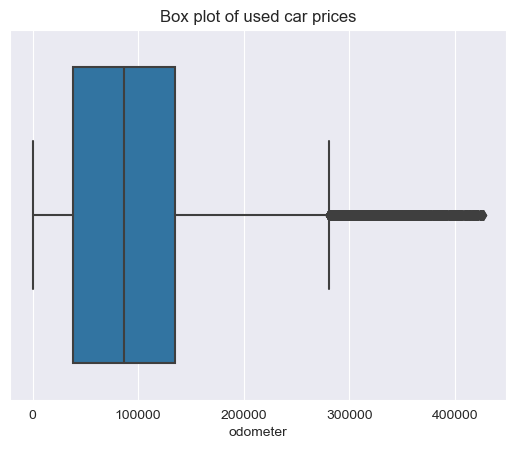

In [14]:
original_df = remove_upper_outeliers(original_df, 'odometer', k=3)
sns.boxplot(x=original_df['odometer']).set(title="Box plot of used car prices")

print("Quartiles")
original_df['odometer'].quantile([0.25, 0.5, 0.75])

Konačno, pogledajmo box-plot vrijednosti značajke "year"

Quartiles


0.25    2008.0
0.50    2013.0
0.75    2017.0
Name: year, dtype: float64

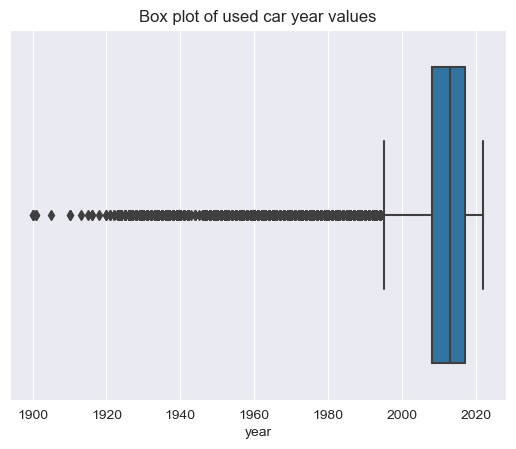

In [15]:
sns.boxplot(x=original_df['year']).set(title="Box plot of used car year values")
print("Quartiles")
original_df['year'].quantile([0.25, 0.5, 0.75])

Također primijećujemo određeni broj outliera, no ne u tolikoj količini kao za price ili odometer. U ovom slučaju, outliere ne uklanjam koristeći IQR metodu, jer bi to uklonilo većinu automobila koji su proizvedeni u prvoj polovici 20. stoljeća. Stoga, uklanjam slučajeve u kojima su ljudi navjerojatnije namjerno stavljali besmisleno niske vrijednosti. Proizvoljno odabirem 1930 godinu kao novu granicu, ispod koje uklanjam sve primjere. Smatram da je vrlo malo vjerojatno da će se u prodaji pronaći neki automobil proizveden prije 1930. godine - u takvim slučajevima, radi se o muzejskim primjercima koji se najvjerojatnije prodaju drugim kanalima, a ne preko Craigslista.

Quartiles


0.25    2008.0
0.50    2013.0
0.75    2017.0
Name: year, dtype: float64

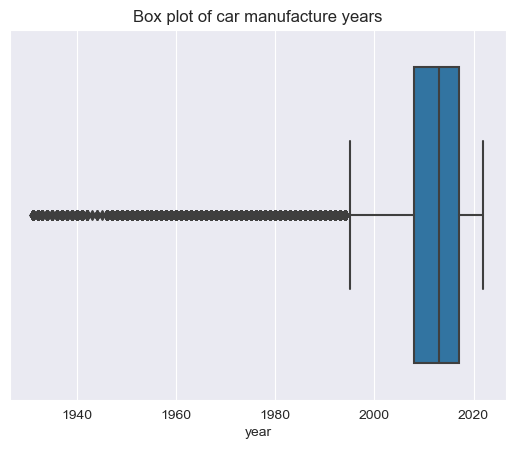

In [16]:
YEAR_LOWER_BOUND = 1930

original_df = original_df[(original_df.year > YEAR_LOWER_BOUND)]
sns.boxplot(x=original_df['year']).set(title="Box plot of car manufacture years")

print("Quartiles")
original_df['year'].quantile([0.25, 0.5, 0.75])


Sada kada smo uklonili (veće) outliere iz numeričkih stupaca year, odometer i price, možemo detaljnije pogledati njihove distribucije koristeći histograme.

Quartiles


0.25     7495.0
0.50    15499.0
0.75    27590.0
Name: price, dtype: float64

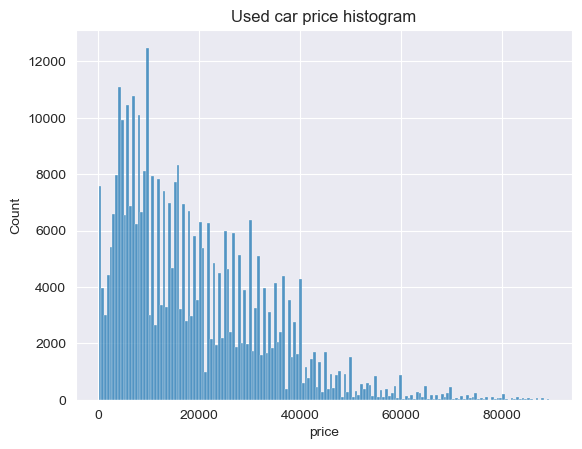

In [17]:
sns.histplot(x=original_df['price']).set(title="Used car price histogram")
print("Quartiles")
original_df['price'].quantile([0.25, 0.5, 0.75])

Iz dobivenog histograma i kvartila, možemo zaključiti da se većina automobila dostupnih za prodaju nalazi ispod 40,000$. Također, po grafu izgleda kao da bi se vrijednosti potencijalno mogle ravnati po pomaknutoj normalnoj distribuciji, iako za definitivnu potvrdu bi bilo potrebno uraditi odgovarajući statistički test.

quartiles


0.25     38483.0
0.50     87325.0
0.75    135223.0
Name: odometer, dtype: float64

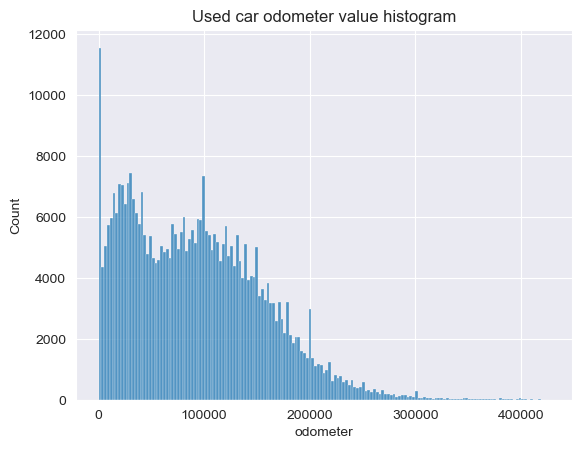

In [18]:
sns.histplot(x=original_df['odometer']).set(title="Used car odometer value histogram")
print("quartiles")
original_df['odometer'].quantile([0.25, 0.5, 0.75])

Ovaj histogram izgleda više-manje kako bi i očekivali, s većinom vrijednosti grupiranih ispod 200,000 milja. Zanimljivo je za primijetiti relativno veliku količinu automobila s vrlo malom vrijednosti odometra - pretpostavka je, kao što sam već rekao, da se u tom slučaju radi ili o novim automobilima, koji još nisu prešli niti jednu milju, ili o kolekcionarskim automobilima koji se ne voze kako bi sačuvali vrijednost.


Quartiles


0.25    2008.0
0.50    2013.0
0.75    2017.0
Name: year, dtype: float64

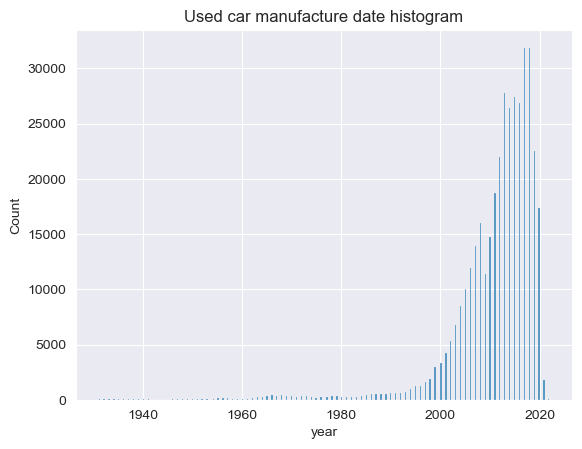

In [19]:
sns.histplot(x=original_df['year']).set(title="Used car manufacture date histogram")
print("Quartiles")
original_df['year'].quantile([0.25, 0.5, 0.75])

Iz histograma datuma proizvodnje možemo primijetiti da je većina automobila u prodaji proizvedena unazad nekoliko zadnjih godina, te da se s smanjenjem godine proizvodnje količina automobila dostupnih za prodaju smanjuje eksponencijalno.

## 2.2 Analiza i čišćenje kategorijskih značajki

Za početak, pogledajmo količinu jedinstvenih vrijednosti za svaku od kategoričkih varijabli

In [20]:
original_df[categorical].nunique()

region            404
manufacturer       42
model           27233
condition           6
cylinders           8
fuel                5
title_status        6
transmission        3
drive               3
size                4
type               13
paint_color        12
state              51
dtype: int64

Možemo vidjeti da imamo razumne količine jedinstvenih vrijednosti za većinu kategorijskih značajki, uz iznimku značajke model, za koju postoji 27861 jedinstvena vrijednost. Ovo je rezultat toga da su ljudi samostalno unosili model svog automobila, umjesto da su odabirali iz predefiniranih vrijednosti s stranice. Stoga je npr. jedna osoba koja prodaje svoju Toyotu Yaris upisala "Yaris", druga "yaris 2013", a treća "toyota yaris", rezultirajući u 3 jedinstvene vrijednosti, iako se u stvarnosti radi o jednom modelu automobila. Stoga, ukoliko bi željeli koristiti ovu značajku za treniranje modela, potrebno je što više ujednačiti nazive modela, odnosno smanjiti broj jedinstvenih vrijednosti te značajke.

Sada možemo pogledati i distribuciju značajki po njihovim jedinstvenim vrijednostima

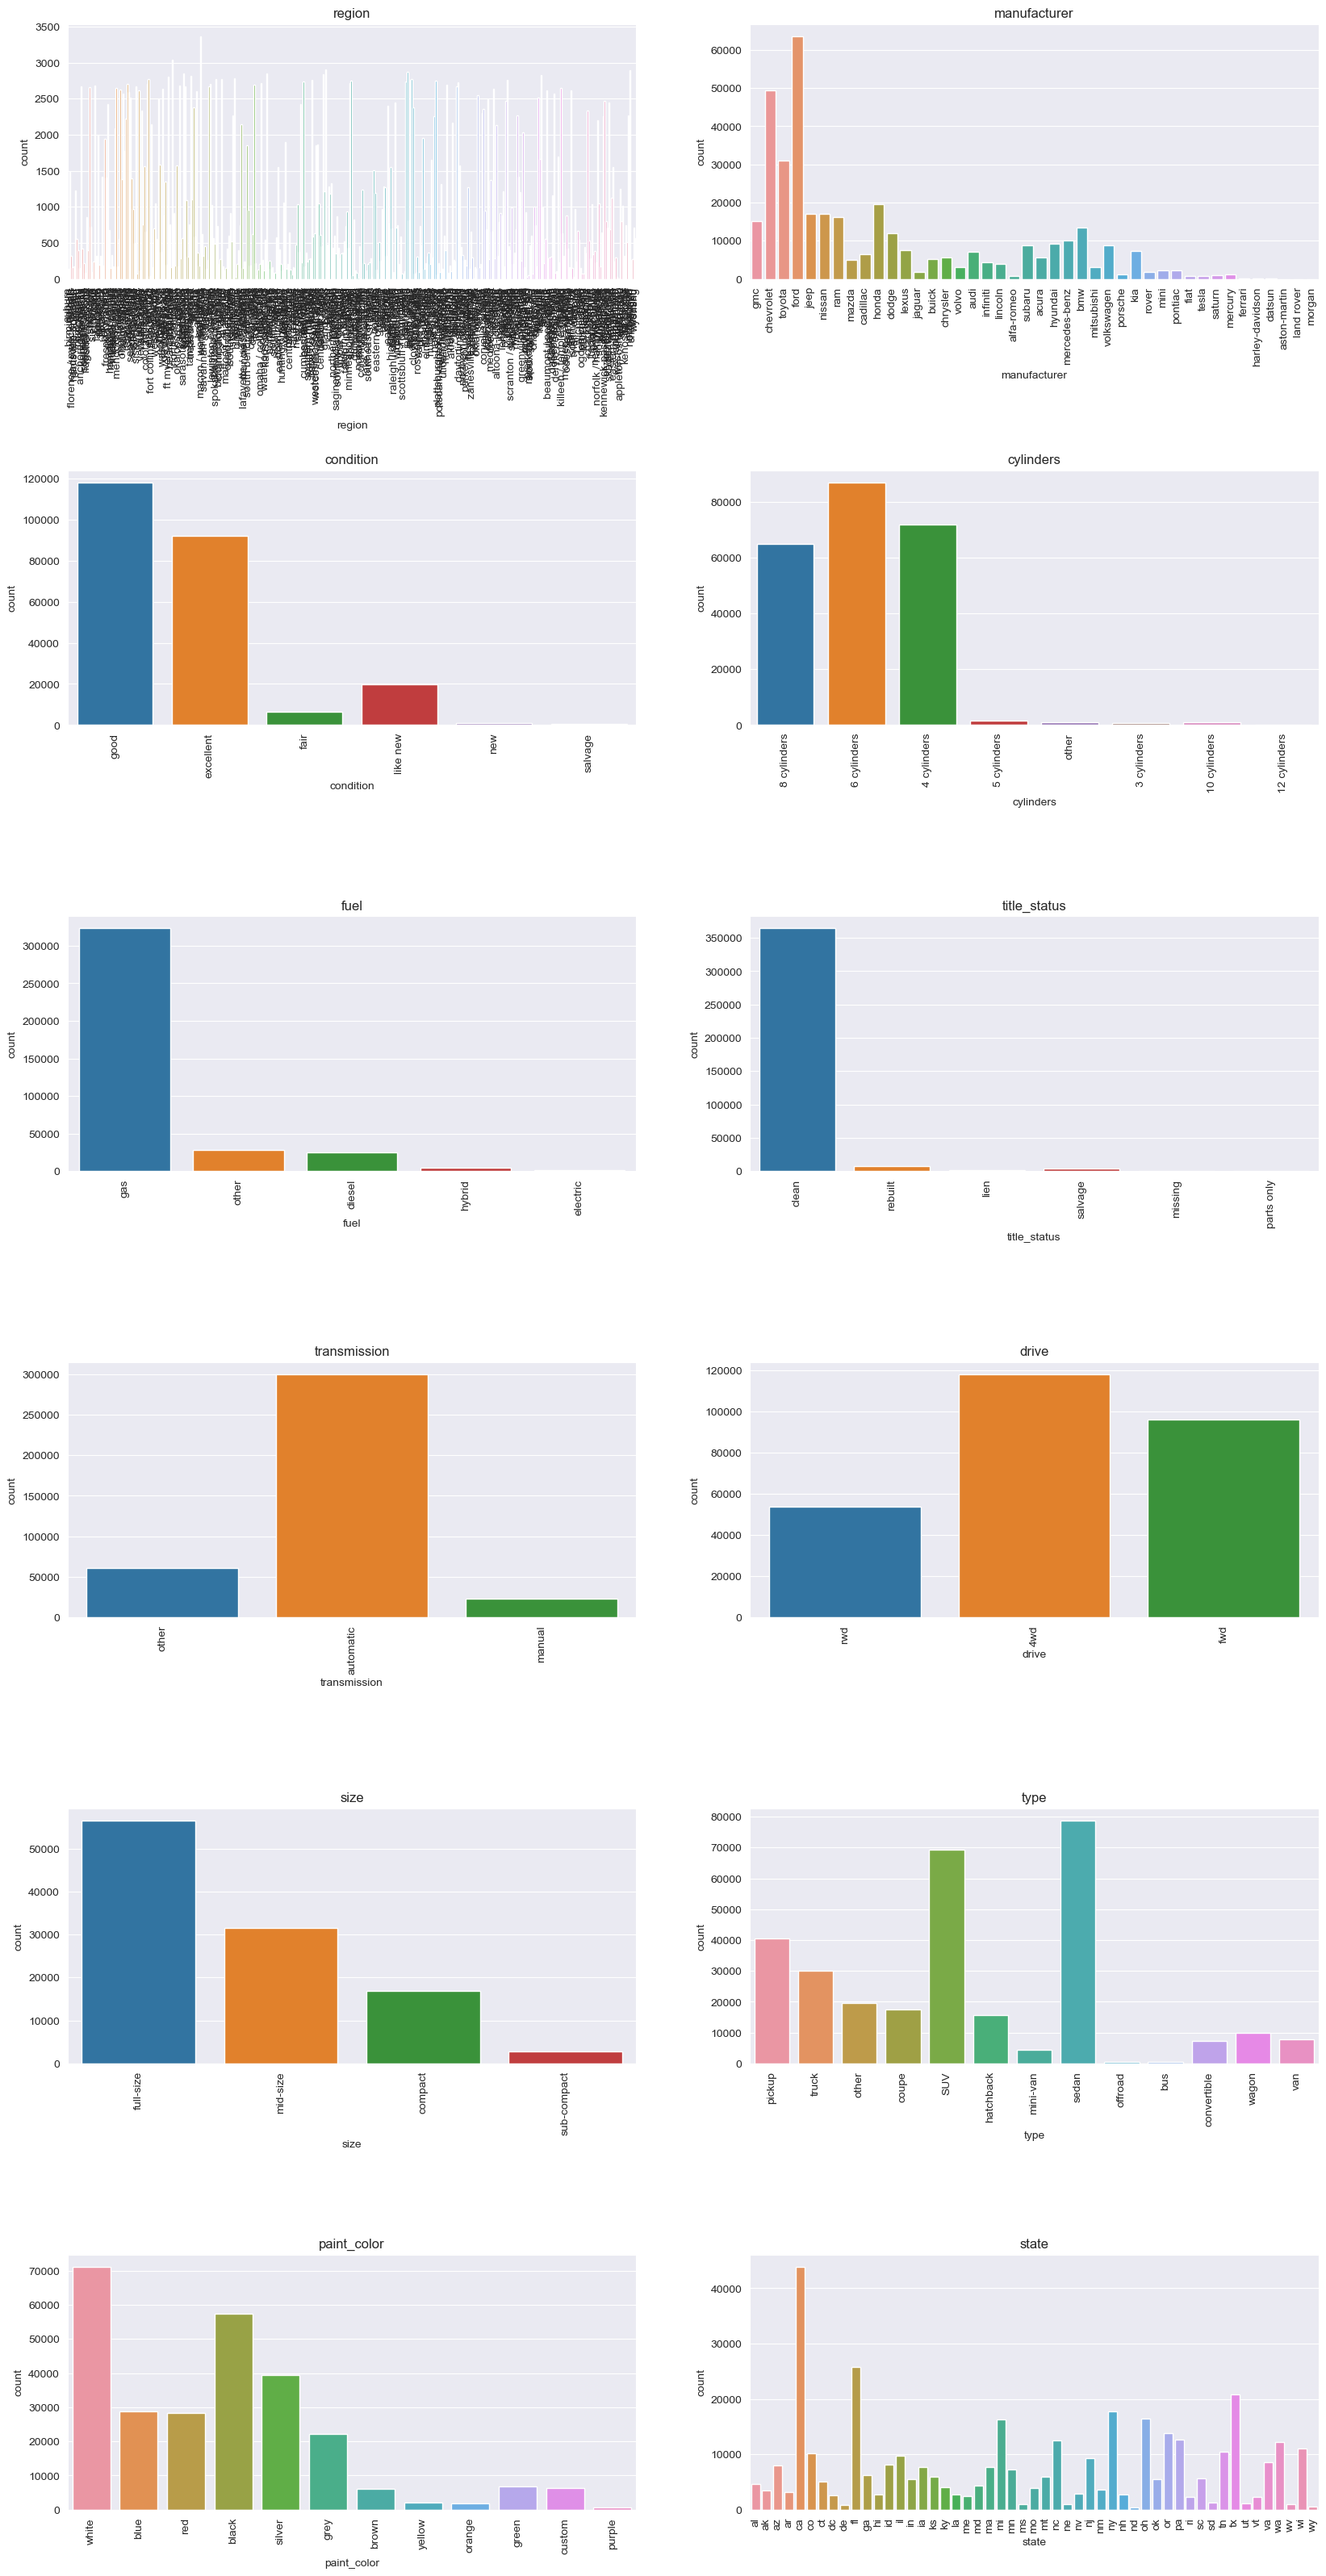

In [21]:
fig, ax = plt.subplots(6, 2, figsize=(20, 40))
fig.subplots_adjust(hspace=0.75)
original_df = original_df.reset_index(drop=True)

#sns.countplot(x=original_df['fuel'])
categorical_no_model = [e for e in categorical if e != "model"]
for feature, subplot in zip(categorical_no_model, ax.flatten()):
    sns.countplot(x=original_df[feature], ax=subplot).set(title=feature)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Bitno je napomenuti da ove vizualizacije ne uzimaju u obzir null vrijednosti. Općenito govoreći, možemo primijetiti popriličnu varijabilnost između distribucije različitih kategoričkih značajki. No, općenito govoreći većini značajki je zajedničko da je frekvencija jedne ili nekoliko značajki značajno veća od frekvencije preostalilh značajki - primjerice, većina vozila ima tip goriva "gas", title status "clean" ili je tipa "SUV" ili "sedan". Ovo je očekivano - poznatno, primjerice, je da u SAD-u većina ljudi vozi SUV-ove i "pick-up" kamione, te vozi vozila s automatskim mjenjačima. Također, određene vrijednosti su gotovo nezastupljene - primjerice, tip pogona "electric", ili auti s 12 cilindara. No, opet, ovakva distribucija ima smisla, jer primjerice poznato je da je broj novih električnih vozila relativno malen - stoga je očekivano da će rabljenih vozila biti još manje, dok su automobili s 12 cilindara najčešće tzv. "supercars", kojih ima vrlo malo u prodaji. Stoga smatram da su ove distribucije reprezentivne te da nema (puno) pogrešaka u podacima. Podatak o distribuciji podataka unutar iste značajke nam je koristan jer prilikom odabira značajki želimo odabrati značajke s većom varijabilnošću, jer one u pravilu više pridnose predikciji ciljane varijable. Što se tiče outliera, ne uočavam neke pretjerane outliere koje bi bilo potrebno odbaciti.


## 2.3 Analiza korelacije između značajki

Jedna korisna informacija koju također možemo istražiti je postojanje korelacije između značajki. Ovo nam je bitno iz dva razloga: 1) želimo da postoji (što veća) korelacija između naših prediktorskih značajki te naše ciljanje značajke (price), kako bi naš model mogao što bolje naučiti predvidjeti cijenu. 2) Želimo što manju kolinearnost između prediktorskih značajki, jer ona može dovesti do raznih problema prilikom treniranja i evaluacije modela, kao što je smanjena spososbnost generalizacije, teža interpretacija modela i slično.

Prvo, pogledajmo korelacije između numeričkih varijabli. Za to sam koristio korisnu Pandasovu methodu df.corr(), koja računa korelacijski koeficijent između svakog para numeričkih značajki. Bitno je naglasiti da sam koristio tzv. Spearman rank correlation metodu za računanje koeficijenata, a ne Pearsonov korelacijski koeficijent, koji je podrazumijevana metoda koju koristi df.corr() funkcija. Ovo sam napravio iz razloga što je Spearmanova metoda neparametarska a Pearsonova parametarska, a pošto ne mogu garantirati da su moji podaci raspodijeljeni po normalnoj distribuciji, odlučio sam "ići na sigurno" i koristiti neparametarsku metodu.

C:\Users\dsmoljan\AppData\Local\Temp\ipykernel_20560\2317992650.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(original_df.corr(method="spearman"),


<Axes: >

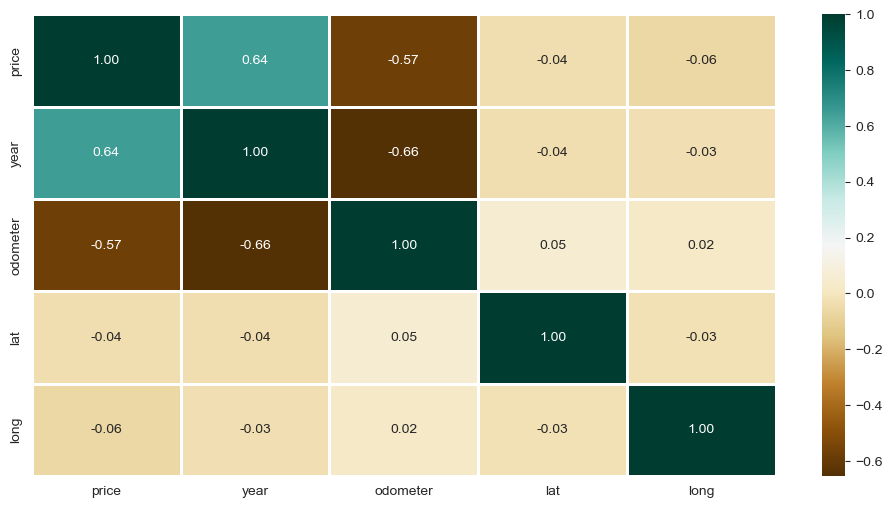

In [22]:
plt.figure(figsize=(12, 6))
sns.heatmap(original_df.corr(method="spearman"),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

Vidimo očekivane rezultate - postoji relativno jaka negativna korelacija između značajki year i price te odometar i price. Također postoji korelacija između značajki year i odometer, što ima smisla - stariji auti će biti više voženi, te stoga imati i veću vrijednost odometra. Iako bi ovo mogao biti dovoljno dobar razlog za uklanjanje jedne od te dvije značajke, pošto između njih postoji koreliranost, smatram da bi time ipak izgubili dio korisnih informacija, posebice za slučajeve u kojima je npr. auto relativno nov, ali mu je cijena ispodprosječno mala jer je prešao puno milja.

Što se tiče značajki lat i long, vidimo da one nisu korelirane s značajkom price, stoga ćemo ih neću koristiti prilikom treniranja.

Sada bi htjeli procijeniti zavisnost između značajke price i kategoričkih značajki, kako bismo mogli lakše odrediti koje od tih značajki uzeti a koje ne. Međutim, naravno, za to ne možemo koristiti istu metodu kao u prijašnjem slučaju, kad smo računali korelaciju između dvije numeričke značajke, već nam je potrebna metoda koja može testirati postoji li korelacija između kategoričke i numeričke značajke. Srećom, postoji jedna upravo takva metoda - ANOVA.

ANOVA nam omogućuje da (indirektno) provjerimo postoji li veza između promatrane kategoričke i numeričke varijable tako da podijeli kategoričke podatke u grupe prema mogućim vrijednostima kategoričke varijable, i za svaku grupu računa varijancu. Ukoliko postoji statistički značajna razlika između varijanci grupa, to ukazuje na to da bi mogla postojati korelacija između značajki. Ukoliko ne postoji statistički značajna razčika između varijanci, možemo zaključiti da korelacije između značajki najvjerojatnije nema.

Međutim, ANOVA ima nekoliko pretpostavki, jedna od kojih je normalna distribucija numeričke značajke. Stoga, prvo ćemo provjeriti zadovoljava li distribucija značajke price normalnu razdiobu, za što možemo koristit nekoliko statističkih testova. Ja sam odabrao D'Agostinov K**2 test, koji je implementiran u sklopu Scipyeve metode normaltest(). Nulta hipoteza, HO = distribucija se ravna po normalnoj distribuciji. H1 = distribucija se ne ravna po normalnoj distribuciji. Kao p-vrijednost koristim standardn vrijednost alpha = 0.05


In [23]:
original_df.price.values

array([33590, 22590, 39590, ..., 34990, 28990, 30590], dtype=int64)

In [24]:
stat, p = normaltest(original_df.price.values)
print(p)
if (p < 0.05):
    print("Rejecting H0 - distribution can not be considered normal under current p-value")
else:
    print("Fail to reject H0. Distribution can be considered normal under current p-value")

0.0
Rejecting H0 - distribution can not be considered normal under current p-value


Nažalost, prema navedenom testu, dobivamo da se distribucija značajke price ne ravna po normalnoj distribuciji, stoga ne možemo koristit ANOVA-u. Preostaje nam njena neparametarska varijanta, Kruskal-Wallis.

In [25]:
from scipy.stats import kruskal

#copy_df = original_df.copy(deep=True).sample(n=500)
copy_df = original_df.copy(deep=True)
for categorical_var in categorical:
    if categorical_var == "model":
        print("Skipping")
        continue
    possible_values = set(copy_df[categorical_var].dropna().unique())
    statistic, p_value = kruskal(*[copy_df['price'][copy_df[categorical_var] == category] for category in possible_values], nan_policy="propagate")

    alpha = 0.05
    print(p_value)
    if p_value < alpha:
        print(f"{categorical_var}: There is evidence of a significant association with price.")
    else:
        print(f"{categorical_var}: There is no significant association with price.")

0.0
region: There is evidence of a significant association with price.
0.0
manufacturer: There is evidence of a significant association with price.
Skipping
0.0
condition: There is evidence of a significant association with price.
0.0
cylinders: There is evidence of a significant association with price.
0.0
fuel: There is evidence of a significant association with price.
0.0
title_status: There is evidence of a significant association with price.
0.0
transmission: There is evidence of a significant association with price.
0.0
drive: There is evidence of a significant association with price.
0.0
size: There is evidence of a significant association with price.
0.0
type: There is evidence of a significant association with price.
0.0
paint_color: There is evidence of a significant association with price.
0.0
state: There is evidence of a significant association with price.


Na prvi pogled sve izgleda super - dobili smo da su sve kategoričke varijable snažno korelirane! Odlično, zar ne?
Ne baš. Ako pogledamo konkretne p-vrijednosti koje je naš test vratio, vidimo da je svaka p-vrijednost 0 - očekivao bi da će barem neka od značajki imati nešto veću p vrijednost. Moja pretpostavka zašto je došlo do ovoga je zbog velikog broja primjera -> p-vrijednosti imaju svojstvo da teže prema 0 s povećanjem broja primjera [(https://www.researchgate.net/publication/270504262_Too_Big_to_Fail_Large_Samples_and_the_p-Value_Problem)](https://www.researchgate.net/publication/270504262_Too_Big_to_Fail_Large_Samples_and_the_p-Value_Problem). Stoga, oslanjanje na p-vrijednost pri velikoj količini podataka (što ova zasigurno je) može biti opasno. Iz tog razloga, prilikom odabira kategoričkih varijabli neću se oslanjati na p-vrijednosti, već na intuiciju i vizualizacije.

Stoga, jedino što nam je preostalo je pogledati vizualizaciju distribucije značajke price ovisno o kategoriji određene kategorijske značajke. Ovo je efektivno vizualizacija (sličnog, ne istog) pristupa koji koristi i ANOVA.

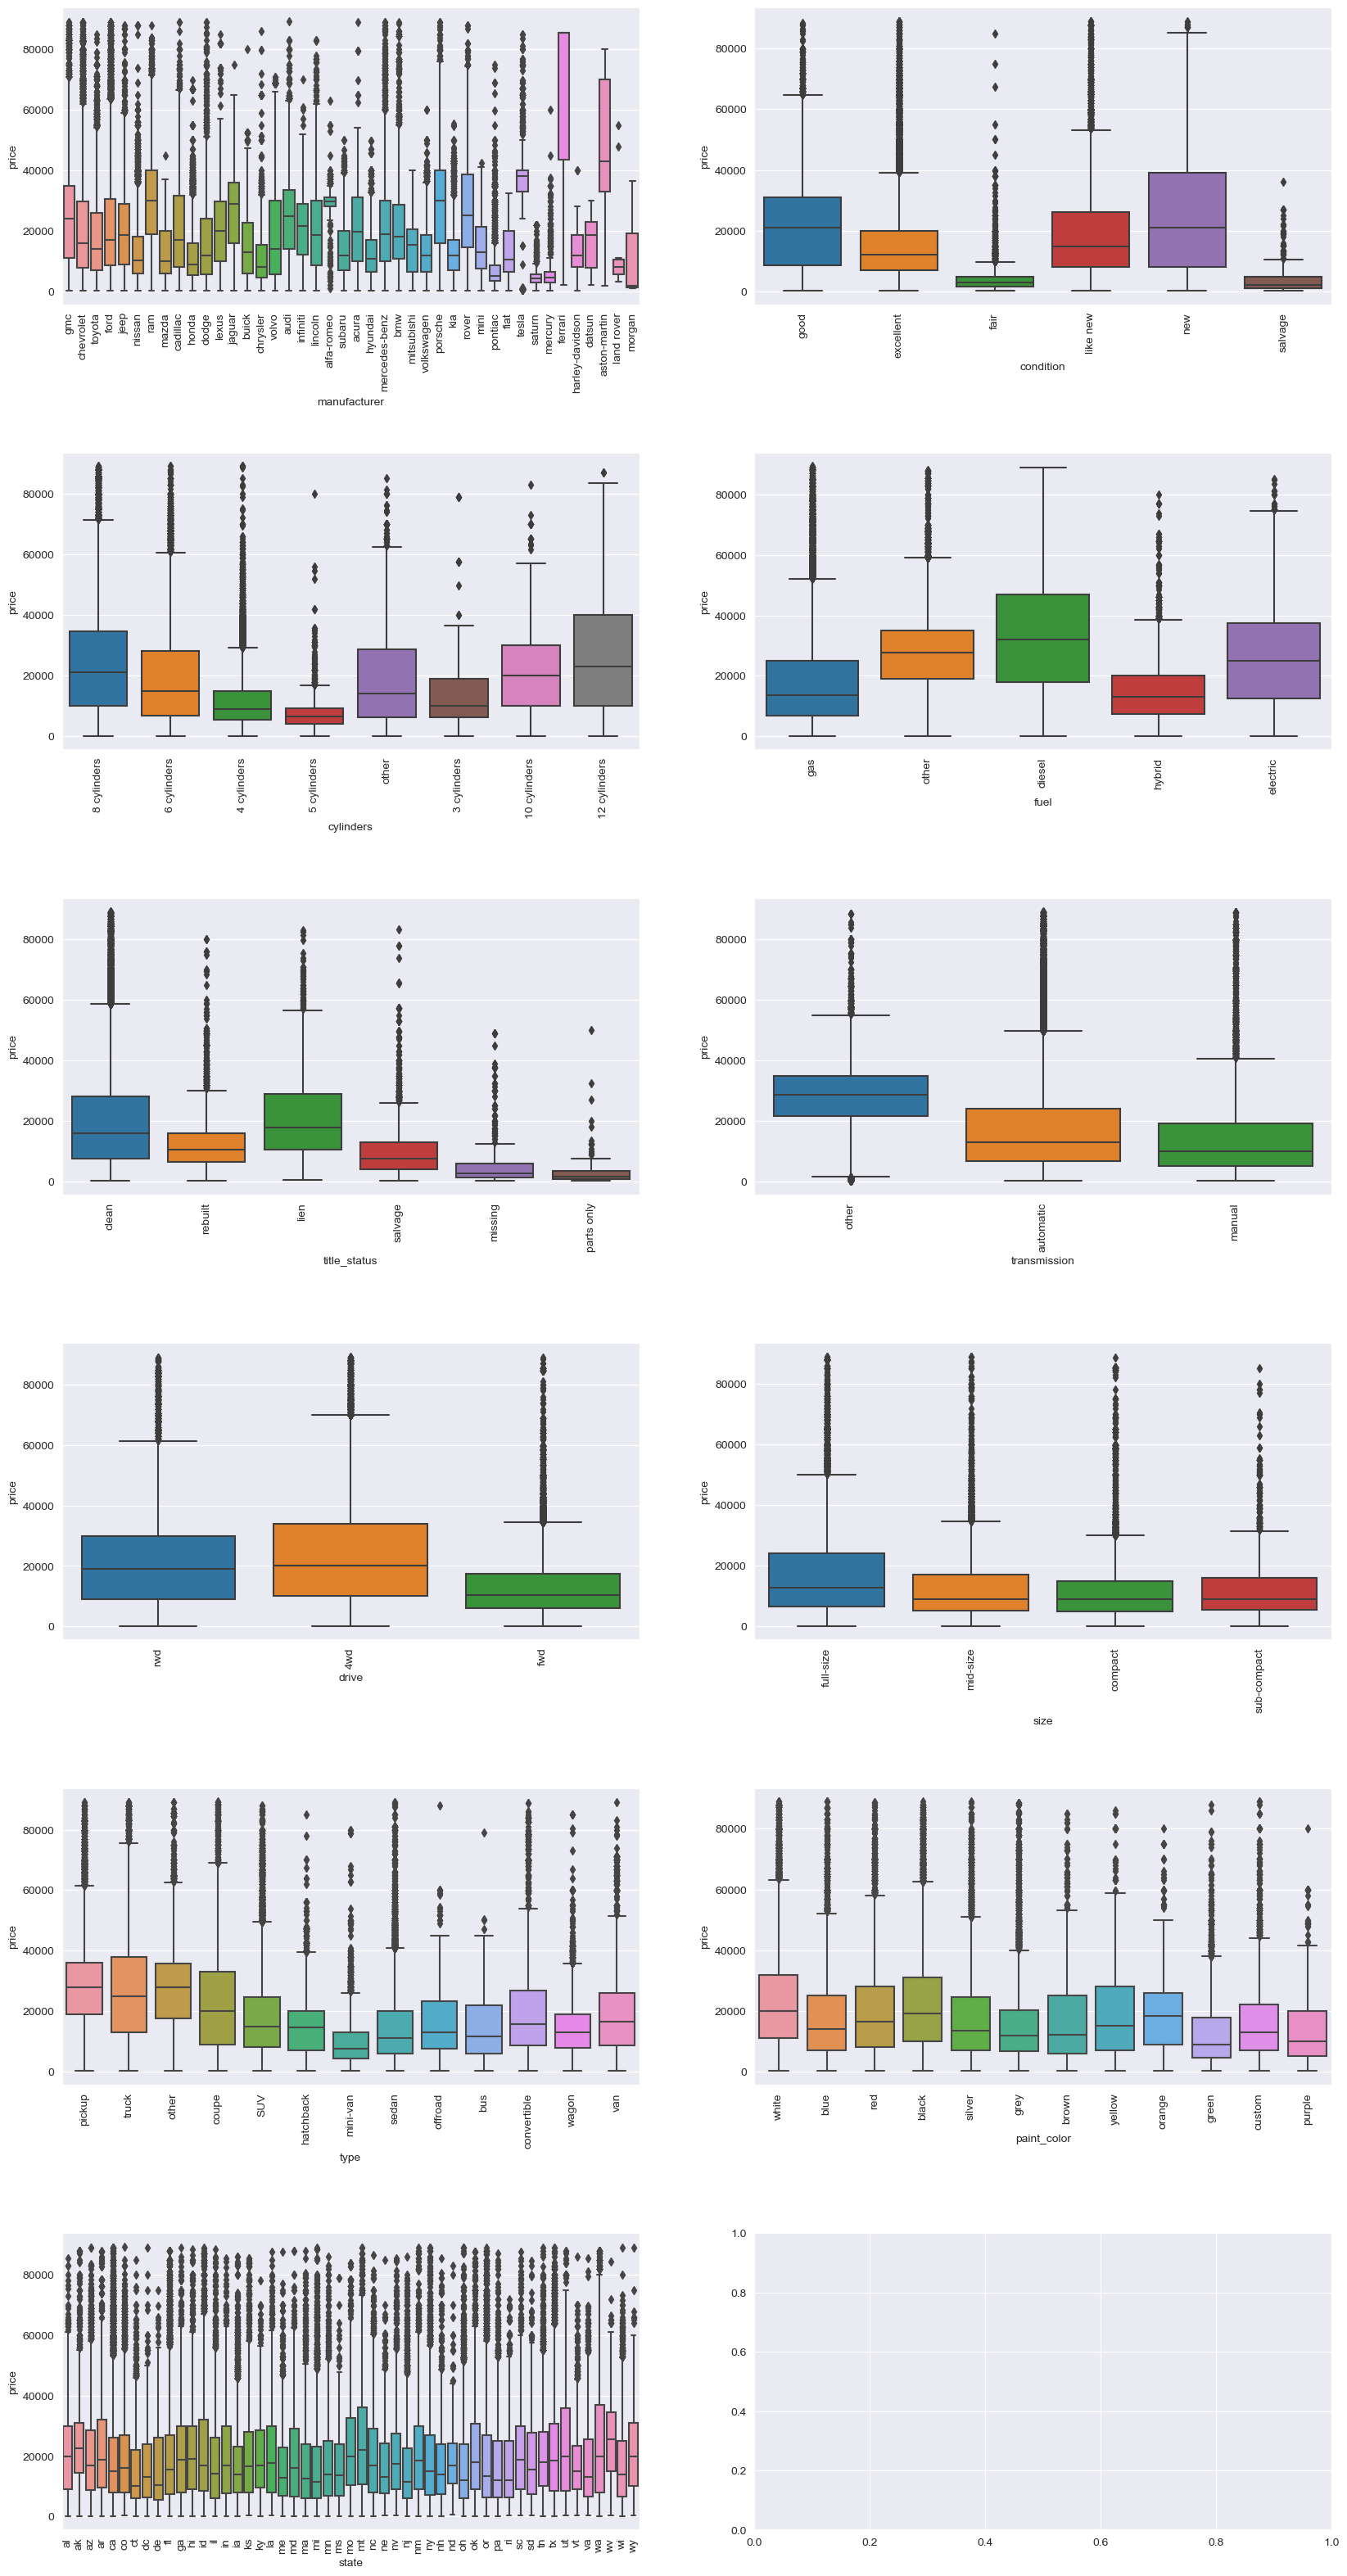

In [26]:
fig, ax = plt.subplots(6, 2, figsize=(20, 40))
fig.subplots_adjust(hspace=0.5)
filtered_categories = ["model", "region"]
filtered_categorical = [cat for cat in categorical if cat not in filtered_categories]
for cat, subplot in zip(filtered_categorical, ax.flatten()):
    sns.boxplot(x=cat, y='price', data=original_df, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Iz ove vizualizacije već možemo znatno bolje procijeniti situaciju. Vidimo da postoji očita ovisnost između određenih kategoričkih značajki i značajke cijena - primjerice, manufacturer, cylinders ili fuel na prvi pogled utječu na distribuciju značajke price, te su stoga dobri kandidati za korištenje u našem modelu. S druge strane, značajke size, paint color pa čak i state ne izgledaju kao da imaju preveliki utjecaj, što može ukazivati da nisu dobri kandidati za prediktorske značajke. Osobno, posebno mi je bio zanimljiv izostanak (značajnije) korelacije značajki state i price - osobno sam očekivao da će postojati veća korelacija, po logici da su neke američke države znatno bogatije od drugih te da će onda i cijene rabljenih automobila u njima biti veće. Ovo je još jedan primjer zašto se uvijek pametnije oslanjati na konkretne podatke, statističke testove i vizualizacije prije donošenja odluke nego na samu intuiciju.

Korelacije značajke "model" nisam prikazao pomoću ovog grafa, jer ta značajka sadrži preko 27,000 različitih vrijednosti i njena vizualizacija ovim tipom grafa nema smisla.


## 2.4 Odabir značajki i kreiranje novih značajki

Na osnovu informacija iz prijašnjih poglavlja, možemo izvršiti odabir značajki. Zbog nedostatka korelacije, uklanjam značajku size. Također sam odlučio ukloniti značajke "state" i "region", pošto su one vezane za SAD te bi mi ograničile buduće predikcije na SAD, te također ne izgleda kao da pretjerano utječu na distribuciju cijene (za slučaj značajke state, region zbog velikog broja različitih vrijednosti nisam vizualizirao).

In [27]:
original_df = original_df.drop(["size", "state", "region"], axis=1)

Slijedeće, primijetio sam stupac "year" koji označava datum proizvodnje automobila. Međutim, nije nebitno je li automobil proizveden 2013 kupljen kao rabljeni 2015 ili 2019 -> odnosno, uz informaciju o godini proizvodnje automobila, bitna nam je i informacija u kojem trenutku je automobil stavljen u prodaju, kako bi mogli odrediti njegovu starost u trenutku prodaje, pošto je to ono što kupci ustvari gledaju. Stoga, na temelju značajki "year" i "posting_date" računam novu značajku, "age", koja određuje starost automobila u trenutku prodaje. Nakon kreiranja nove značajke age, značajke posting_date i year mi više nisu potrebne te ih uklanjam.

In [28]:
def extract_year(posting_date):
    if posting_date:
        # example posting_date format: 2021-04-04T03:21:31-0600
        return int(posting_date.strip()[:4])
    else:
        return None

original_df['age'] = original_df.apply(lambda row: extract_year(row['posting_date']) - row['year'] if pd.notnull(row['year']) and pd.notnull(row['posting_date']) else None, axis=1)

original_df = original_df.drop(['year', 'posting_date'], axis=1)

original_df.tail()

,url,region_url,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,image_url,description,lat,long,age
384454,https://wyoming.craigslist.org/ctd/d/atlanta-2...,https://wyoming.craigslist.org,23590,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,sedan,NaN,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,33.786500,-84.445400,2.0
384455,https://wyoming.craigslist.org/ctd/d/atlanta-2...,https://wyoming.craigslist.org,30590,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,sedan,red,https://images.craigslist.org/00x0x_15sbgnxCIS...,Carvana is the safer way to buy a car During t...,33.786500,-84.445400,1.0
384456,https://wyoming.craigslist.org/ctd/d/atlanta-2...,https://wyoming.craigslist.org,34990,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,hatchback,white,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,33.779214,-84.411811,1.0
384457,https://wyoming.craigslist.org/ctd/d/atlanta-2...,https://wyoming.craigslist.org,28990,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,33.786500,-84.445400,3.0
384458,https://wyoming.craigslist.org/ctd/d/atlanta-2...,https://wyoming.craigslist.org,30590,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,coupe,NaN,https://images.craigslist.org/00Y0Y_lEUocjyRxa...,Carvana is the safer way to buy a car During t...,33.779214,-84.411811,2.0


Konačno, uklanjam sve nepotrebne značajke: url, region_url, VIN, image_url, lat, long. Uklanjam i značajku "description", jer iako bi se potencijalno mogao koristiti neka feature extraction metoda za tekst (poput bag-of-words ili TF/IDF), smatram da bi količina korisnih informacija koje bi tako dobili bila relativno mala, zbog relativno velikog šuma, odnosno beskorisnih informacija u tom polju, a unijela bi dodatne komplikacije u naš model, odnosno značajke te zahtijevala korištenje modela s većim kapacitetom.


In [29]:
original_df = original_df.drop(['url', 'region_url', 'VIN', 'image_url', 'lat', 'long', 'description'], axis=1)
original_df.columns

Index(['price', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'age'],
      dtype='object')

## 2.5 Analiza i transformacija null vrijednosti + transformacija oblika podataka

U ovom poglavlju ću napraviti kratku analizu nedostajećih (null) značajki, te ukloniti one nedostajuće značajke za koje smatram da bi nam mogle predstavljati prepreku u daljnoj analizi i zaključivanju.

Prvo, pogledajmo koliko točno nedostajućih vrijednosti postoji u svakom stupcu

In [30]:
original_df.isnull().sum()

price                0
manufacturer     13817
model             4250
condition       146435
cylinders       156202
fuel              2119
odometer             0
title_status      7186
transmission      1511
drive           117015
type             82587
paint_color     113472
age                  0
dtype: int64

Također, broj nedostajućih vrijednosti možemo pogledati i kroz vizualizaciju

<Axes: >

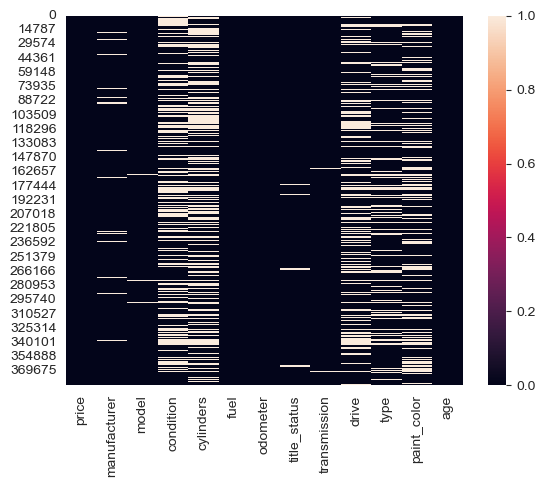

In [31]:
#https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj
sns.heatmap(original_df.isnull(), cbar=True)

U navedenoj vizualizaciji, y-os predstavlja indeks oređenog podatka, dok boje predstavljaju radi li se o nedostajućem podatku ili ne -> nedostajući podaci
označeni su smeđom bojom, a "ispravni" podaci svijetlo-ljubičastom. Na x-osi prikazane su značajke. Iz navedene vizualizacije možemo naslutiti kako neke značajke sadrže znatno više nedostajućih vrijednosti nego drugi - primjerice, značajka cylinders. Kako bi saznali točan udio nedostajućih vrijednosti u ukupnim vrijednostima, pogledajmo iduću vizualizaciju:

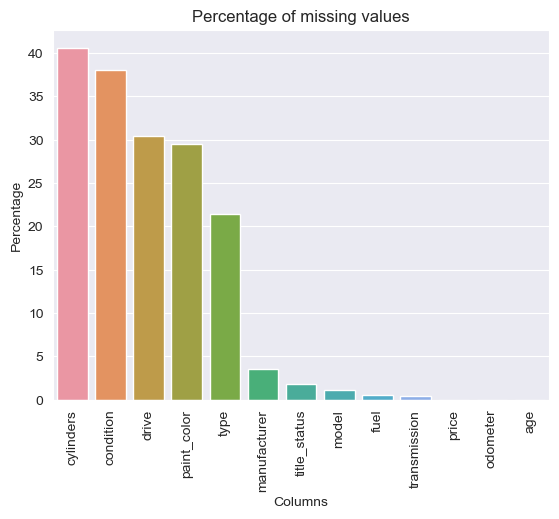

In [32]:
missing_percentage = (original_df.isnull().sum() / len(original_df)) * 100
missing_percentage = missing_percentage.sort_values(ascending=False)
sns.barplot(x=missing_percentage.index, y=missing_percentage)
plt.title('Percentage of missing values')
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.show()

Možemo vidjeti kako stupci cylinders i condition sadrže najveći postotak nedostajućih značajki, dok u stupci drive, paint_color i type nedostaje nešto manji, ali i dalje popriličan postotak značajki. Ostali stupci imaju neke nedostajuće značajke, ali u puno manjem postotku nego navedeni stupci.

Također možemo primijetiti da su jedini stupci u kojem nedostaju vrijednosti kategorički. Ovo je bitna informacija jer su nam potrebne različite tehnike za rješavanje numeričkih i kategoričkih nedostajućih vrijednosti.

Postoji nekoliko pristupa za uklanjanje nedostajućih značajki. Naravno, najjednostavniji pristup je ukloniti sve primjere koji sadrže null značajke, no učinimo li to, ostati će nam vrlo malo podataka. Stoga, potrebno je razmotriti druge pristupe.

Istraživanjem dataseta, primijetio sam jedan slučaj koji se događa relativno često - u slučaju kad je stupac "manufacturer" prazan, informacija o proizvođaču automobila se često nalazi u sklopu stupca "model" - npr. u tom slučaju, umjesto da vrijednost stupca "model" bude "Focus", biti će "Ford Focus", i slično. Ovu činjenicu možemo iskoristiti kako bismom nadopunili dio nedostajućih vrijednosti iz stupca "manufacturer" s podacima iz stupca "model". Također, pritom ćemo ukloniti i naziv proizvođača iz stupca model.

In [33]:
manufacturers_list = list(original_df['manufacturer'].unique())
manufacturers_list = [x for x in manufacturers_list if str(x) != 'nan']

print(f"Number of missing values in manufacturer column before applying method: {original_df[['manufacturer']].isna().sum().item()}")

def assign_manufacturer(row):
    manufacturer_value = row['manufacturer']
    model_value = row['model']

     # check if manufacturer is null and model contains any value from m_list
    if pd.isnull(manufacturer_value) and any(x in model_value.lower() for x in manufacturers_list):
        for man in manufacturers_list:
            if man in model_value.lower():
                # assign the matched manufacturer value to the manufacturer column
                row['manufacturer'] = man
                # remove the matched manufacturer value from the model string
                row['model'] = model_value.lower().replace(man, '').strip()
                break

    return row

original_df = original_df.apply(assign_manufacturer, axis=1)
print(f"Number of missing values in manufacturer column after applying method: {original_df[['manufacturer']].isna().sum().item()}")

# jednom kad nadomjestiš podatke, možeš dropati stupac model jer ti više ne treba
original_df = original_df.drop('model', axis=1)

Number of missing values in manufacturer column before applying method: 13817
Number of missing values in manufacturer column after applying method: 13126


Kao što vidimo, uspjeli smo nadomjestiti cca. 700 nepostojećih vrijednosti koristeći opisanu metodu. Preostale nedostajeće vrijednosti nadomjestiti ćemo zajedno s nedostajućim vrijednostima ostalih stupaca. Usput sam uklonio i značajku model, jer mi više neće biti potrebna. U teoriji, bilo bi moguće iskoristiti i te podatke kroz neki oblik text featurea, poput TF/IDF-a, no to bi višestruko povećalo količinu podataka te zbog povećane dimenzionalnosti ulaznih podataka možda zahtijevalo modele s većim kapacitetom, pa sam odlučio jednostavno ne koristiti tu značajku. No, za neko buduće istraživanje bilo bi zanimljivo proučiti utjecaj korištenja i te značajke na konačne performanse modela.

Idući korak, uklanjanje nedostajućih vrijednosti preostalih stupaca se pokazao kao najteži korak u cijelom zadatku, jer sam pokušavao u svakom koraku odabrati najbolje moguće rješenje, a kao što ćemo uskoro vidjeti, najbolja rješenja često mogu biti u suprotnosti jedno s drugim. Za početak, razmislimo malo koje su najčešće metode uklanjanja nepostojećih vrijednosti, primijenjive na kategoričke podatke, jer samo ti podaci u našem slučaju imaju nepostojeće vrijednosti. Postoji nekoliko jednostavnih pristupa, primjerice nadomještanje najučestalijom vrijednošću, ili nadomještanje dodavanjem nove vrijednosti, npr. "missing". No, ovo nisu optimalni pristupi; dodavanje nove vrijednosti "missing" može uvesti pristranost u model te na kraju dovesti do prenaučenosti na train setu. Nadomještanje najčestalijom vrijednošću je nešto bolji pristup, no njegov je nedostatak što može uvesti nebalansiranost jedne klase u podatke, odnosno u slučaju kad su podaci već nebalansirani (kakvi naši za dosta značajki jesu), može ju pogoršati. Konačno, posljednji pristup je ukloniti sve primjere s vrijednostima null, no očito je da je on vrlo loš u slučaju kad imamo puno nedostajućih vrijednosti, kao sada. Zato sam odlučio ne koristiti niti jedan od ovih pristupa, več sam pokušao pronaći drugi način

Naišao sam na Scikit-ovu metodu IterativeImputer, koja služi za uklanjanje nedostajućih vrijednosti iz podataka. Ideja ove metode je da se svaka od nedostajućih vrijednosti procjenuje na temelju vrijednosti iz ostalih stupaca, koristeći neku od dostupnih metoda. Jednom kad se sve vrijednosti u nekom stupcu nadopune, prelazi se na idući stupac, i tako dalje, sve dok postoje nedostajuće vrijednosti. Ovo je jednostavna, ali dosta efektna metoda, koja se u praksi često može pokazati bolja nego neke jednostavnije metode, poput nadopune najčešćom vrijednosti, ili nadopune srednjom vrijednosti. No, postoji jedan veliki problem s ovom metodom - ne podržava (izravan) rad s kategoričkim značajkama, već očekuje da su sve značajke u numeričkom obliku, što je očito problem za moje kategoričke podatke. Jedno rješenje ovog problema je, pošto ionako moramo enkodirati sve kategoričke varijable na neki način, enkodirati ih koristeći label encoding, jednostavan pristup u kojem se svakoj klasi jednostavno dodijeli neki broj koji ju predstavlja. Ukoliko bi odabrali ovaj način kodiranja, IterativeImputer bi uspješno mogao predvidjeti nedostajuće kategoričke značajke. No, ovaj način enkodiranja nije dobar za kategoričke varijable koje prirodno nemaju redoslijed, kakvih je većina naših kategoričkih varijabli (uz iznimku "cylinders"), jer može navesti model da nauči predviđati ciljanu varijablu pretpostavljajući da postoji poredak između kategoričkih  varijabli, iako u stvarnosti klasa označena brojem 5 nije po ničemu "ispred" klase označene brojem 1. Dakle, riješili bi jedan problem na dobar način (nedostajuće vrijednosti) na štetu drugog problema (kodiranje kategoričkih varijabli). Činilo se da ću, koji god pristup odaberem, morati žrtvovati nešto.

To mi se nije svidjelo, stoga sam se odlučio za slijedeći, znatno složeniji, no u mom mišljenju bolji pristup, koji uspjeva na ispravan način riješiti oba problema.

1) Napraviti podjelu na train-test, te sve predikcije nedostajućih vrijednosti računati isključivo na osnovu train seta
2) Enkodirati kategoričke podatke koristeći label encoding, te spremiti enkoder za kasnije korištenje na test i pred setu.
3) Sad kad su svi kategorički podaci enkodirani kao numerički, iskoristiti iterative imputer za računanje nedostajućih vrijednosti. Spremiti naučeni iterative imputer za korištenje na test i pred setu.
4) Prebaciti kodiranje kategoričkih varijabli iz label encodinga u one-hot encoding, te konačni model trenirati na featureima enkodiranim pomoću one-hot encodinga.
5) Prilikom testiranja/predikcije, koristiti isti pipeline i spremljene enkodere i imputere za uklanjanje nedostajućih vrijednosti i kodiranje.


Posebno bi naglasio korak 1, koji je vrlo česta greška koju sam primijetio da je dosta ljudi na internetu napravilo. Naime, namjeravam trenutni dataset podijeliti u 2 dataseta: train i test, kako bi mogao evaluirati svoj model. Jednostavniji i naivniji pristup bi bio prvo primijeniti IterativeImputer na cijeli skup podataka, te ga zatim podijeliti u train i test. No, ovo je pogrešno, jer na taj način možemo unijeti pristranost (bias) u model, te narušiti integritet našeg modela, jer će dio informacija iz test seta biti indirektno prisutan u podacima za treniranje. Ispravan pristup je "naučiti" IterativeImputer isključivo na train datasetu, te zatim, koristeći naučeni imputer transformirati test set, a i buduće primjere za predikciju, ukoliko će i oni imati nedostajućih vrijednosti. Ista stvar vrijedi i za normalizaciju podataka - potrebno je prvo podijeliti podatke u train/test set, izračunati transformacije isključivo na train setu, te zatim koristeći dobivene parametre transformirati train i test set. Za više informacija, preporučam: [Link 1](https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/), [Link 2](https://stats.stackexchange.com/questions/95083/imputation-before-or-after-splitting-into-train-and-test), [Link 3](https://datascience.stackexchange.com/questions/53138/which-comes-first-multiple-imputation-splitting-into-train-test-or-standardiz#:~:text=The%20correct%20way%20is%20to,on%20to%20the%20test%20set.)

Stoga, idući korak je podijeliti dataset u train i test. Za podjelu koristim omjer 80-20, koji je često korišten u ML-u. Još jedna često korištena podjela je 70-10-20, u slučaju kad želimo koristiti i tzv. validacijski skup podataka, koji nam služi, primjerice, za pronalazak optimalnih hiperparametara ili neke metode sprječavanja pretreniranja poput early stoppinga. No, za pronalazak optimlanih hiperparametara, u slučaju kad mi je to bilo potrebno, odlučio sam koristiti k-cross-validation, dok early stopping nisam koristio.

Prije same podjele, prvo prilagođavam LabelEncodere, potrebne u idućim koracima nad cjelokupnim podacima.

In [34]:
def get_label_encoders(full_df, categorical_list):
    """
    Fits a label encoder over each categorical column in full_df, determined by categorical_list
    Returns a dictionary of label encoders for each categorical column. DOES NOT transform the original dataframe!
    Ignores null values, i.e does NOT create a label encoding for null values in a column
    :param full_df:
    :param categorical_list:
    :return:
    """
    copy_df = full_df.copy(deep=True)
    label_encoders_dict = {}
    for cur_col in copy_df[categorical_list].columns:
        series = copy_df[cur_col]
        new_label_encoder = LabelEncoder()
        copy_df[cur_col] = pd.Series(
            new_label_encoder.fit_transform(series[series.notnull()]),
            index=series[series.notnull()].index
        )
        label_encoders_dict[cur_col] = new_label_encoder
    return label_encoders_dict

def apply_label_encoding(dataframe, label_encoders_dict):
    """
    Given a dataframe with some categorical columns, and a suitable label encoder, applies label encodings from the encoder
    onto the categorical columns of the dataframe, thus converting them to numbers.
    Skips nan and null values.
    :param dataframe:
    :param label_encoders_dict:
    :return:
    """
    for category_name, label_encoder in label_encoders_dict.items():
        non_null_mask = dataframe[category_name].notnull()  # Boolean mask to select non-null values
        dataframe.loc[non_null_mask, category_name] = label_encoder.transform(dataframe.loc[non_null_mask, category_name])

categorical = ['manufacturer', 'condition', 'cylinders',
               'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']

label_encoders = get_label_encoders(original_df, categorical)

In [35]:
original_df # zbog načina rada get_label_encoders, očekivano je da stupci original_df ostanu u "običnom" obliku

,price,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
0,33590,gmc,good,8 cylinders,gas,57923.0,clean,other,NaN,pickup,white,7.0
1,22590,chevrolet,good,8 cylinders,gas,71229.0,clean,other,NaN,pickup,blue,11.0
2,39590,chevrolet,good,8 cylinders,gas,19160.0,clean,other,NaN,pickup,red,1.0
3,30990,toyota,good,8 cylinders,gas,41124.0,clean,other,NaN,pickup,red,4.0
4,15000,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
384454,23590,nissan,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,NaN,2.0
384455,30590,volvo,good,NaN,gas,12029.0,clean,other,fwd,sedan,red,1.0
384456,34990,cadillac,good,NaN,diesel,4174.0,clean,other,NaN,hatchback,white,1.0
384457,28990,lexus,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,3.0


In [36]:
train_df, test_df = train_test_split(original_df, test_size=0.2, random_state=42)
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Train size: 307567
Test size: 76892


In [37]:
apply_label_encoding(train_df, label_encoders)
apply_label_encoding(test_df, label_encoders)

In [38]:
train_df

,price,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
366335,5777,31,NaN,NaN,2,171000.0,0,0,NaN,NaN,NaN,15.0
222382,18000,31,0,5,2,43772.0,0,0,2,NaN,0,32.0
96908,61888,13,NaN,NaN,0,45012.0,0,0,0,8,9,3.0
853,7980,4,NaN,NaN,2,156000.0,0,0,NaN,NaN,NaN,8.0
289365,29990,14,NaN,NaN,0,125937.0,0,0,0,8,NaN,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
259178,10991,25,NaN,3,2,77591.0,0,0,1,9,3,7.0
365838,9257,39,NaN,NaN,2,123077.0,0,0,1,9,NaN,9.0
131932,3500,7,1,5,2,131000.0,0,0,2,8,2,21.0
146867,3180,16,2,5,2,189140.0,0,0,1,NaN,NaN,18.0


Sada kada smo kategoričke značajke kodirali koristeći LabelEncoder, možemo iskoristiti IterativeImputer kako bi nadomjestili nedostajuće značajke.

In [39]:
# koristi KNN s recimo 15ak susjeda, to radi dobro i brzo
# za razliku od random foresta lol
# mislim da je bitno da koristis classifier a ne regressor, da ti ne izade iz raspona inta
iterative_imputer = IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=15), random_state=0)
iterative_imputer.fit(train_df)

IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=15), random_state=0)

In [40]:
transformed_data_train = iterative_imputer.transform(train_df)
transformed_data_test = iterative_imputer.transform(test_df)

train_df = pd.DataFrame(transformed_data_train, columns=train_df.columns)
test_df = pd.DataFrame(transformed_data_test, columns=test_df.columns)
display(train_df)
display(test_df)

,price,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
0,5777.0,31.0,0.0,3.0,2.0,171000.0,0.0,0.0,1.0,0.0,5.0,15.0
1,18000.0,31.0,0.0,5.0,2.0,43772.0,0.0,0.0,2.0,7.0,0.0,32.0
2,61888.0,13.0,0.0,6.0,0.0,45012.0,0.0,0.0,0.0,8.0,9.0,3.0
3,7980.0,4.0,0.0,4.0,2.0,156000.0,0.0,0.0,0.0,10.0,10.0,8.0
4,29990.0,14.0,0.0,6.0,0.0,125937.0,0.0,0.0,0.0,8.0,9.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
307562,10991.0,25.0,0.0,3.0,2.0,77591.0,0.0,0.0,1.0,9.0,3.0,7.0
307563,9257.0,39.0,0.0,3.0,2.0,123077.0,0.0,0.0,1.0,9.0,10.0,9.0
307564,3500.0,7.0,1.0,5.0,2.0,131000.0,0.0,0.0,2.0,8.0,2.0,21.0
307565,3180.0,16.0,2.0,5.0,2.0,189140.0,0.0,0.0,1.0,0.0,9.0,18.0


,price,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
0,4500.0,16.0,0.0,5.0,2.0,233487.0,0.0,0.0,1.0,8.0,10.0,9.0
1,22990.0,16.0,2.0,3.0,2.0,25307.0,0.0,0.0,1.0,9.0,8.0,2.0
2,2500.0,16.0,2.0,3.0,2.0,149523.0,0.0,0.0,1.0,3.0,9.0,21.0
3,15869.0,39.0,0.0,3.0,2.0,37056.0,0.0,0.0,1.0,9.0,0.0,2.0
4,9998.0,13.0,0.0,3.0,2.0,114429.0,0.0,1.0,1.0,9.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76887,12999.0,28.0,0.0,3.0,4.0,71544.0,0.0,0.0,1.0,0.0,1.0,10.0
76888,2100.0,32.0,2.0,3.0,2.0,130011.0,0.0,0.0,1.0,9.0,10.0,14.0
76889,15995.0,7.0,0.0,3.0,2.0,91297.0,0.0,0.0,1.0,0.0,0.0,4.0
76890,5500.0,16.0,0.0,3.0,2.0,160000.0,0.0,0.0,1.0,9.0,5.0,12.0


U teoriji, mogli smo podake prebaciti direktno iz label encodinga u one-hot encoding, bez međukoraka ponovne pretvorbe u "prave" kategoričke vrijednosti, no preferiram ovu metodu a) zbog provjere da je sve izvršeno ispavno b) zbog lakše kasnije pretvorbe one-hot enkodiranih značajki u "prave" značajke

In [41]:
def reverse_encode_labels(dataframe, label_encoders):
    for cat_name, label_encoder in label_encoders.items():
        dataframe[cat_name] = label_encoder.inverse_transform(dataframe[cat_name].astype(int))

# Display the reverse-encoded DataFrame
reverse_encode_labels(train_df, label_encoders)
reverse_encode_labels(test_df, label_encoders)
display(train_df)
display(test_df)

,price,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
0,5777.0,nissan,excellent,4 cylinders,gas,171000.0,clean,automatic,fwd,SUV,grey,15.0
1,18000.0,nissan,excellent,6 cylinders,gas,43772.0,clean,automatic,rwd,other,black,32.0
2,61888.0,ford,excellent,8 cylinders,diesel,45012.0,clean,automatic,4wd,pickup,silver,3.0
3,7980.0,bmw,excellent,5 cylinders,gas,156000.0,clean,automatic,4wd,truck,white,8.0
4,29990.0,gmc,excellent,8 cylinders,diesel,125937.0,clean,automatic,4wd,pickup,silver,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
307562,10991.0,mazda,excellent,4 cylinders,gas,77591.0,clean,automatic,fwd,sedan,custom,7.0
307563,9257.0,toyota,excellent,4 cylinders,gas,123077.0,clean,automatic,fwd,sedan,white,9.0
307564,3500.0,chevrolet,fair,6 cylinders,gas,131000.0,clean,automatic,rwd,pickup,brown,21.0
307565,3180.0,honda,good,6 cylinders,gas,189140.0,clean,automatic,fwd,SUV,silver,18.0


,price,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
0,4500.0,honda,excellent,6 cylinders,gas,233487.0,clean,automatic,fwd,pickup,white,9.0
1,22990.0,honda,good,4 cylinders,gas,25307.0,clean,automatic,fwd,sedan,red,2.0
2,2500.0,honda,good,4 cylinders,gas,149523.0,clean,automatic,fwd,coupe,silver,21.0
3,15869.0,toyota,excellent,4 cylinders,gas,37056.0,clean,automatic,fwd,sedan,black,2.0
4,9998.0,ford,excellent,4 cylinders,gas,114429.0,clean,manual,fwd,sedan,black,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76887,12999.0,mini,excellent,4 cylinders,other,71544.0,clean,automatic,fwd,SUV,blue,10.0
76888,2100.0,pontiac,good,4 cylinders,gas,130011.0,clean,automatic,fwd,sedan,white,14.0
76889,15995.0,chevrolet,excellent,4 cylinders,gas,91297.0,clean,automatic,fwd,SUV,black,4.0
76890,5500.0,honda,excellent,4 cylinders,gas,160000.0,clean,automatic,fwd,sedan,grey,12.0


In [42]:
train_df.isna().sum()

price           0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
age             0
dtype: int64

In [43]:
test_df.isna().sum()

price           0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
age             0
dtype: int64

Sada kada smo se riješili svih nedostajućih podataka, možemo nastaviti s obradom podataka. Slijedeći korak koji je koristan je skaliranje podataka u raspon [0,1], kako razlike u skali ne bi otežale treniranje nekih modela koji su osjetjivi na to - postoje modeli koje baš briga. Opet, parametre transformacije dobivamo na train setu, te ih samo primijenjujemo na test setu. Ovo možemo jednostavno napraviti koristeći Scikitovu klasu MinMaxScaler. Potreban nam je po jedan scaler za svaku od numeričkih značajki, odnosno 3 zasebna scalera. Mogli bi koristiti jedan MinMax scaler, no to bi predstavljalo problem prilikom korištenja scalera za predikciju, kada ne bi imali značajku price, stoga sam odlučio jednostavno koristiti 3 zasebna scalera.

In [44]:
# odvojeni scaleri kako bi kasnije tijekom predikcije mogao lakše transformirati dataframe ako nemam stupac column
price_scaler = MinMaxScaler()
odometer_scaler = MinMaxScaler()
age_scaler = MinMaxScaler()

train_df[['price']] = price_scaler.fit_transform(train_df[['price']])
train_df['odometer'] = odometer_scaler.fit_transform(train_df[['odometer']])
train_df['age'] = age_scaler.fit_transform(train_df[['age']])

test_df[['price']] = price_scaler.transform(test_df[['price']])
test_df[['odometer']] = odometer_scaler.transform(test_df[['odometer']])
test_df['age'] = age_scaler.transform(test_df[['age']])

In [45]:
display(train_df[['price', 'odometer', 'age']])
display(test_df[['price', 'odometer', 'age']])

,price,odometer,age
0,0.063607,0.402135,0.175824
1,0.200580,0.102937,0.362637
2,0.692400,0.105853,0.043956
3,0.088294,0.366860,0.098901
4,0.334943,0.296162,0.153846
...,...,...,...
307562,0.122036,0.182468,0.087912
307563,0.102604,0.289436,0.109890
307564,0.038090,0.308069,0.241758
307565,0.034504,0.444795,0.208791


,price,odometer,age
0,0.049296,0.549084,0.109890
1,0.256500,0.059514,0.032967
2,0.026884,0.351629,0.241758
3,0.176700,0.087143,0.032967
4,0.110908,0.269099,0.109890
...,...,...,...
76887,0.144538,0.168248,0.120879
76888,0.022401,0.305743,0.164835
76889,0.178112,0.214700,0.054945
76890,0.060502,0.376267,0.142857


Konačno, možemo primijeniti poslijednju potrebnu transformaciju prije nego što prijeđemo na evaluaciju modela, a to je one-hot encoding kategoričkih varijabli. Moramo paziti da encodinge računamo nad cijelim setom podataka, uključujući train i test, inače bi konačni rezultat mogao biti različit broj stupaca u train i test setu.


In [46]:
# https://stackoverflow.com/questions/55525195/do-i-have-to-do-one-hot-encoding-separately-for-train-and-test-dataset
full_df = pd.concat([train_df, test_df], axis=0)
oh_enc = OneHotEncoder(sparse_output=False, handle_unknown = 'ignore', drop='first')
oh_enc.fit(full_df[categorical])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [47]:
oh_cols_train = pd.DataFrame(oh_enc.transform(train_df[categorical]))
oh_cols_train.index = train_df.index
train_df = train_df.drop(categorical, axis=1)
train_df = pd.concat([train_df, oh_cols_train], axis=1)
train_df

,price,odometer,age,0,1,2,3,4,5,6,...,79,80,81,82,83,84,85,86,87,88
0,0.063607,0.402135,0.175824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.200580,0.102937,0.362637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.692400,0.105853,0.043956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.088294,0.366860,0.098901,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.334943,0.296162,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307562,0.122036,0.182468,0.087912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307563,0.102604,0.289436,0.109890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
307564,0.038090,0.308069,0.241758,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307565,0.034504,0.444795,0.208791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [48]:
oh_cols_test = pd.DataFrame(oh_enc.transform(test_df[categorical]))
oh_cols_test.index = test_df.index
test_df = test_df.drop(categorical, axis=1)
test_df = pd.concat([test_df, oh_cols_test], axis=1)
test_df

,price,odometer,age,0,1,2,3,4,5,6,...,79,80,81,82,83,84,85,86,87,88
0,0.049296,0.549084,0.109890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.256500,0.059514,0.032967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.026884,0.351629,0.241758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.176700,0.087143,0.032967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.110908,0.269099,0.109890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76887,0.144538,0.168248,0.120879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76888,0.022401,0.305743,0.164835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
76889,0.178112,0.214700,0.054945,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76890,0.060502,0.376267,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
print(train_df.shape)
print(test_df.shape)

(307567, 92)
(76892, 92)


Ovdje bi se samo kratko osvrnuo na jednu opasnu zamku koja se može dogoditi prilikom enkodiranja kategoričkih varijabli u one-hot (znam jer se dogodio i meni :). Konkretno, kad koristimo one-hot encoding, za kategoričku varijablu koja ima N različitih mogućih vrijednosti, stvaramo N novih stupaca, odnosno one-hot značajki $x_1, x_2, ..., x_N$. Iako je to vrlo dobar način kodiranja podataka i za većinu modela preferabilan u odnosu na label encoding koji sam isto spomenuo, ima jedan problem. Problem je u tome što smo time stvorili tzv. savršenu korelaciju između navedenih značajki - čim je jedna od tih značajki bila 1, to bi značilo da su sve ostale značajke 0. Odnosno, $x_1 + x_2 + ... + x_n = 1$. Ovo također znači ako znamo vrijednosti N-1 značajki, možemo zaključiti kakva je vrijednost posljednje preostale značajke. Ovo je problem za npr. linearnu regresiju, koja pretpostavlja nepostojanje multikolnearnosti u podacima. Za detaljnije objašnjenje preporučam [Link 1](https://12ft.io/proxy?&q=https%3A%2F%2Ftowardsdatascience.com%2Fone-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a), [Link 2](https://inmachineswetrust.com/posts/drop-first-columns/).

Problem sam rješio jednostavno, tako da sam postavio parametar drop=True u pozivu metode OneHotEncoder, čime su se iz enkodiranih podataka uklonile reprezentacije prve kategorije za svaku klasu, na taj način rješavajući navedeni problem.

Ovaj problem se inače naziva dummy variable trap, valjda jer samo dummyi padaju na njega :)

Sada kada su naši podaci u odgovarajućem obliku, preostaje nam izdvojiti značajku "price" u zaseban array, y_train i y_test.

In [50]:
y_train = train_df.pop('price').values
y_test = test_df.pop('price').values

In [51]:
x_train = train_df.values
x_test = test_df.values


Konačno, spremam sve korišene imputere, enkodere i scalere u .pkl objekt, kako bi ih mogao kasnije koristiti prilikom obrade podataka za predikciju.

In [52]:
preprocessing_dict = {"label_encoders":label_encoders, "one_hot_encoder": oh_enc, "price_scaler":price_scaler, "odometer_scaler":odometer_scaler, "age_scaler":age_scaler}

with open('preprocessing_dict.pkl', 'wb') as file:
    pickle.dump(preprocessing_dict, file)

I to je to! Završili smo s analizom i pripremom podataka za treniranje, te možemo prijeći na svima najdraži dio - modeliranje!

# 3. Kreiranje i evaluacija modela

## 3.1 Korištene metrike

Prije nego što krenemo u analizu modela, kratko ću predstaviti metrike koje sam odlučio koristiti. Naravno, problem koji rješavamo je regresija (varijabla koju predviđamo je numerička), a ne klasifikacija, stoga su nam potrebne metrike za taj problem.

1) Mean Squared Error, MSE - vrlo često korištena metrika u regresijskim problemima. Jednostavno se računa kao $MSE = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$, gdje $y_i$ predstavlja ispravnu vrijednost, a $\hat{y}_i$ vrijednost koju je predvidio naš model. Manje = bolje. Također, uz MSE koristio sam i njenu varijantu MSLE, koja samo logaritmira vrijednosti $y_$ i $\hat{y}_i$ prije oduzimanja. Ova funkcija je nešto otpornija na velike razlike u skali između različitih rješenja i dobra je za slučajeve u kojima MSE "odleti u nebo".

2) Root Mean Squared Error, RMSE - vrlo slična metrika kao i MSE - dok MSE kvadrira svaku razliku $(y_i - \hat{y}_i)$, RMSE ju ne kvadrira. Posljedično, majne je osjetljiv na outliere, te na njega manje utječu velike pogreške, odnosno razlike $(y_i - \hat{y}_i)$. Također sam koristio varijantu RMSE RMSLE, kao i kod MSE.

3) R2 score (Coefficient of determination) - vrlo često korištena metrika u regresijskim modelima. Prednost ove metrike je što daje izlaze na skali [0,1], što olakšava interpretaciju i usporedbu različitih modela. Također, ova metrika ima i jednostavnu interpretaciju - njena vrijednost predstavlja postotak varijabilnosti u ciljanoj varijabli koju je objasnio naš model, i.e ako je R2 vrijednost 0.4 (40%), naš model uspješno objašnjava 40% varijabilnosti u distribuciji ciljane varijable. Naravno, veća vrijednost je bolja. Formulu za R2 možemo napisati kao: $R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$

In [74]:
model_scores = dict()

## 3.2 Cross validation

Prilikom usporedbe modela, koristio sam 5-fold cross validation nad train podacima, te na osnovu dobivenih metrika uspoređivao modele. Najbolji model sam onda testirao nad test datasetom kako bi dobio konačne performanse modela. Prednost korištenja ovog načina

## 3.3 Baseline model
Prilikom izrade i evaluacije modela, uvijek je dobra ideja prvo implementirati vrlo jednostavan model, kojeg bi svi naši "pravi" modeli trebali s lakoćom nadmašiti. Takav model se najčešće naziva baseline model Ovo nam služi kako bi bili sigurni da su naši modeli barem zadovoljavajući, jer ako naš složeni model nije u stanju nadmašiti skroz jednostavan model, onda nam to ukazuje ili na grešku u implementaciji, podacima, ili da model nije prikladan za problem koji rješavamo. Postoji više različitih načina implementacije baseline modela, a jedan dobar način za regresijske probleme je model koji jednostavno vraća srednju vrijednost ili medijan y_train. Stoga, implementirajmo takav model i izračunajmo njegove metrike, opisane u 3.1.



In [81]:
mean_model = mean_value_regressor()
mean_model.fit(y_train)
y_pred = mean_model.predict(y_test)
results = get_metrics(y_test, y_pred)

print(f"MSE: {results['mse']}")
print(f"MSLE: {results['msle']}")
print(f"RMSE: {results['rmse']}")
print(f"RMSLE: {results['rmsle']}")
print(f"R2 score: {results['r2']}")

results['test_MSE'] = results.pop('mse')
results['test_MSLE'] = results.pop('msle')
results['test_RMSE'] = results.pop('rmse')
results['test_RMSLE'] = results.pop('rmsle')
results['test_R2-score'] = results.pop('r2')

model_scores["Baseline"] = results

MSE: 0.025341850827687026
MSLE: 0.01568036846900121
RMSE: 0.1591912397956842
RMSLE: 0.12522127802015603
R2 score: -4.608047867726839e-07


Ovo su rezultati koje bi naši modeli trebali nadmašiti. Zanimljivo je prmijetiti relativno niske vrijednosti MSE i RMSE, no pravi pokazatelj da se radi o lošem baseline modelu je R2 score, koji je izuzetno malen -> 4e-7, što nam pokazuje da model uopće ne objašnjava varijabilnost u podacima. Naravno, ovo je očekivano, jer model za svaki x vrati srednju vrijednost y_train, što znači da nikako ne pokušava objasniti u varijabilnosti podataka.

Sada kada smo imamo referentne metrike, možemo prijeći na prave modele. Odabrao sam 4 modela za implementaciju: linearnu regresiju kao najjednostavniji model, SVM regresor, RandomForest regresor te XGBoost.

# 3.4 Linearna regresija

Najjednostavniji model koji ću impelementirati je ujedino i jedan od najpoznatijih i najčešće korištenih modela u ML, a i statistici općenito. Radi se o modelu linearne regresije.

Bitno je napomenuti da neki od korištenih modela, među njima i linearna regresija, ponekad predviđaju vrijednosti cijene < 0. Kako je to nemoguće (iako koristim min-max skaliranje, 0 nije 0 USD već 100USD), odlučio sam sve takve primjere jednostavno postaviti u 0. U tu svrhu sam napisao minimalan wrapper koji prima bilo koji Scikit estimator, te modificira njegovu predict metodu tako da sve predviđene varijable < 0 postavlja u 0.




In [82]:
wrapped_lr = positive_values_model_wrapper(LinearRegression())
wrapped_lr.fit(x_train, y_train)

scoring = get_cross_validate_scorer()
cv_results = cross_validate(wrapped_lr, x_train, y_train, cv=5, scoring=scoring)

print(f"MSE: {np.mean(cv_results['test_MSE'])}")
print(f"MSLE: {np.mean(cv_results['test_MSLE'])}")
print(f"RMSE: {np.mean(cv_results['test_RMSE'])}")
print(f"RMSLE: {np.mean(cv_results['test_RMSLE'])}")
print(f"R2 score: {np.mean(cv_results['test_R2-score'])}")

model_scores["Linear regression"] = cv_results

MSE: 0.008855688233440906
MSLE: 0.005395348844624105
RMSE: 0.09410387869724968
RMSLE: 0.07345242896798747
R2 score: 0.6517913223854448


Također, kako bi mogao jednostavnije napraviti interpretaciju rezultata modela, te kako bi usput usporedio performanse label encodinga i one-hot encodinga, ponovo ću pokrenuti isti algoeitam ali koristeći label encoding.

In [46]:
 # zbog seeda podjela podataka je ista
label_encoded_train, label_encoded_test = train_test_split(original_df, test_size=0.2, random_state=42)
apply_label_encoding(label_encoded_train, label_encoders)
apply_label_encoding(label_encoded_test, label_encoders)

label_encoded_train = pd.DataFrame(iterative_imputer.transform(label_encoded_train), columns=label_encoded_train.columns)
label_encoded_test = pd.DataFrame(iterative_imputer.transform(label_encoded_test), columns=label_encoded_test.columns)

label_encoded_train[['price']] = price_scaler.transform(label_encoded_train[['price']])
label_encoded_train[['odometer']] = odometer_scaler.transform(label_encoded_train[['odometer']])
label_encoded_train['age'] = age_scaler.transform(label_encoded_train[['age']])

label_encoded_test[['price']] = price_scaler.transform(label_encoded_test[['price']])
label_encoded_test[['odometer']] = odometer_scaler.transform(label_encoded_test[['odometer']])
label_encoded_test['age'] = age_scaler.transform(label_encoded_test[['age']])

label_encoded_y_train = label_encoded_train.pop('price').values
label_encoded_y_test = label_encoded_test.pop('price').values

label_encoded_x_train = label_encoded_train
label_encoded_x_test = label_encoded_test

In [47]:
wrapped_lr = positive_values_model_wrapper(LinearRegression())

scoring = get_cross_validate_scorer()
cv_results = cross_validate(wrapped_lr, label_encoded_x_train, label_encoded_y_train, cv=5, scoring=scoring)

print(f"MSE: {np.mean(cv_results['test_MSE'])}")
print(f"MSLE: {np.mean(cv_results['test_MSLE'])}")
print(f"RMSE: {np.mean(cv_results['test_RMSE'])}")
print(f"RMSLE: {np.mean(cv_results['test_RMSLE'])}")
print(f"R2 score: {np.mean(cv_results['test_R2-score'])}")

MSE: 0.011729639911932075
MSLE: 0.007183041664242998
RMSE: 0.10830313653110872
RMSLE: 0.08475267953734454
R2 score: 0.5387943675578017


Vidimo kako je ova instanca linearne regresije postigla znatno lošije rezultate, što očito ukazuje da one-hot encoding radi značajno bolje nego label encoding.

Korisna stvar kod rada s label encodingom umjesto s one-hot varijablama je i što nam olakšava vizualizaciju utjecaja, odnosno "važnosti" svake od prediktorskih značajki u konačnoj predikciji modela. Utjecaj svake od značajki je predstavljen s vrijednosti koeficijenta svake značajke u modelu linearne regresije. Ovo je super, jer nam daje model čije ponašanje možemo objasniti, za razliku od nekih drugih modela čiji je rad više na principu crne kutije, i.e neuronske mreže.

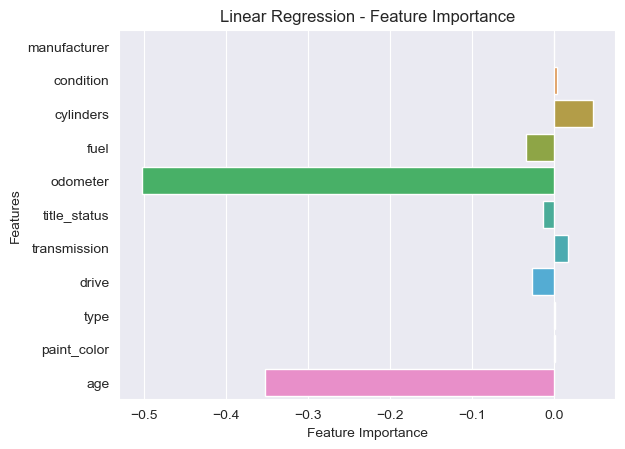

In [55]:
# summarize feature importance
# Plot the feature importance

wrapped_lr = positive_values_model_wrapper(estimator=LinearRegression())
wrapped_lr.fit(label_encoded_x_train, label_encoded_y_train)
feature_importance = pd.Series(wrapped_lr.estimator.coef_, index=label_encoded_x_train.columns)
sns.barplot(x=feature_importance.values, y=feature_importance.index)

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Linear Regression - Feature Importance')

# Show the plot
plt.show()

Koao što možemo vidjeti iz navedene vizualizacije, najbitnija značajka prilikom predikcije cijene je stanje odometra -> što je stanje odometra veće, to će cijena biti manja. Malo manji, ali i dalje snažan negativan utjecaj ima značajka "age" -> opet, što je vozilo starije, to će njegova cijena biti manja. S druge strane, značajka cylinders ima pozitivnu korelaciju, iako ne previše značajnu. S druge strane, najviše me iznenadilo to što značajka "manufacturer" nema gotov nikakv učinak; ovo je bila jedna od značajki za koje sam osobno vjerovao da će imati najveći učinak. Čini se da ni paint color nije dao neke značajne rezultate, kojeg li čuda :)

Postoje i ostale inačice "klasične" regresije koje sam razmišljao isprobati, kao što je Polynomial regression, Ridge regression itd, ali istraživanjem općenitih performansi ML modela, pretpostavio sam da ću najbolje performanse dobiti s nekim od narednih modela, štoga nisam vidio neku potrebu za daljnim isprobavanjem varijanti linearne regresije.

## 3.5 SVM regresor

Slijedeći model koji ću testirati je SVM regresor. U teoriji, ovaj model bi trebao biti moćniji od linearne regresije, jer omogućava opisivanje nelinearnih odnosa između podataka, zahvljajući svojim tzv. jezgrenim funkcijama. Kao jezgrenu funkciju (kernel) koristim radial basis function (RBF) kernel, jer se u mom prijašnjem iskustvu pokazao kao dobra opcija.

In [83]:
# 3.5 SVMRegressor

svm_positive_wrapper = positive_values_model_wrapper(estimator=SVR(kernel = 'rbf', max_iter=10000))

scoring = get_cross_validate_scorer()

cv_results = cross_validate(svm_positive_wrapper, x_train, y_train, cv=5, scoring=scoring)

print(f"MSE: {np.mean(cv_results['test_MSE'])}")
print(f"MSLE: {np.mean(cv_results['test_MSLE'])}")
print(f"RMSE: {np.mean(cv_results['test_RMSE'])}")
print(f"RMSLE: {np.mean(cv_results['test_RMSLE'])}")
print(f"R2 score: {np.mean(cv_results['test_R2-score'])}")

model_scores["SVR"] = cv_results

C:\Users\dsmoljan\anaconda3\envs\carprices\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\dsmoljan\anaconda3\envs\carprices\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\dsmoljan\anaconda3\envs\carprices\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\dsmoljan\anaconda3\envs\carprices\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\dsmoljan\anaconda3\envs\carprices\lib\s

MSE: 0.007635515811108978
MSLE: 0.0048645290702676
RMSE: 0.08737134830983002
RMSLE: 0.06973762420711821
R2 score: 0.6997805559791559


Ovaj model se istaknuo po tome što mu je trebalo daleko najviše vremena za treniranje u odnosu na ostale modele - s parametrom max_iter postavljenim na 10000, 5-cross-validation se izvodila 25 minuta, odnosno 5 minuta po iteraciji. Morao sam koristiti parametar max_iter, jer bez njega postavljenog, ni nakon sat vremena model se nije bio istrenirao.

Rezultati koje je model postigao su OK - uspio je nadmašiti linearnu regresiju, iako ne previše. Naravno, što je parametar max_iter bio veći, model je bolje učio, stoga je vrlo lagano moguće da bi za još veći parametar max_iter model postigao bolje rezultate, no, naravno uz veće vrijeme treniranja. Iz tog razloga, nisam dalje pokušavao s većim vremenom treniranja, nego sam prešao na iduća 2 modela.


## 3.6 RandomForestRegressor

Idući algoritam koji sam odlučio implementirati je random forest regressor. Iako sam istraživajući ovaj algoritam naišao na različita mišljenja o njegovim mogućnostima, učinio mi se zanimljiv, pa sam ga odlučio isprobati. Ovaj algoritam ustvari trenira više različitih random forest modela, te ih onda uprosječuje kako bi dobio konačnu predikciju -> stoga ovaj algoritam spada u tzv. ansamble. Ovo u konačnici može implementirati modelima koji rade znatno bolje. Jedno često upozorenje koje sam primijetio istražujući ovaj model je da je defaultni broj procjenitelja (100) gotovo sigurno prevelik, te da ako želim da mi se model istrenira u razumnom vremenu, moram koristiti niže vrijednosti za broj procijenitelja. Tu bi opcija bila koristiti neku opciju grid-searcha za pronalazak najboljeg broja procjenitelja, ali s obzirom da bi za vrlo velike brojeve procijenitelja ovo potencijalno trajalo jako dugo, odlučio sam jednostavno ručno isprobati nekoliko opcija za broj procjenitelja i pronaći onu koja radi najbolje u razumnom vremenu. Na kraju se vrijednost procjenitelja od 35 pokazala OK, te sam ju koristio za treniranje konačnog modela.

In [84]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=35, max_features=0.5, n_jobs=-1, oob_score=True, verbose=2)

scoring = get_cross_validate_scorer()

cv_results = cross_validate(rf_regressor, x_train, y_train, cv=5, scoring=scoring)

print(f"MSE: {np.mean(cv_results['test_MSE'])}")
print(f"MSLE: {np.mean(cv_results['test_MSLE'])}")
print(f"RMSE: {np.mean(cv_results['test_RMSE'])}")
print(f"RMSLE: {np.mean(cv_results['test_RMSLE'])}")
print(f"R2 score: {np.mean(cv_results['test_R2-score'])}")

model_scores["Random forest regression"] = cv_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  35 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   11.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  22 out of  35 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  35 | elapsed:    7.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    8.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  22 out of  35 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent worker

MSE: 0.0027671107067400746
MSLE: 0.0017254214591302657
RMSE: 0.052599559422553066
RMSLE: 0.04153552943119278
R2 score: 0.8911926020139683


[Parallel(n_jobs=16)]: Done  22 out of  35 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  35 out of  35 | elapsed:    0.2s finished


Jedna praktično korisna stvar u vezi ovog modela je što vrlo učinkovito koristi raspoložive resurse sustava - pretpostavljam zato što treniranje odvojenih metoda može modelirati kao odvojene poslove, što mu omogućava znatno učinkovitiju paralelizaciju -> u praksi, treniranje ovog modela je koristilo gotovo 100% svih 8 jezgri mog procesora, dok je primjerice treniranje SVM-a koristlo tek 15% procesorske snage.

Nadalje, vrijeme potrebno za treniranje ovog modela, koristeći broj procjenitelja 35 i 5-cross-validation je bilo svega oko 2 minute, a model je postigao vrlo impresivne rezultate (pogotovo u pogledu R2-scorea). U usporedbi s SVM-om, koji je nakon 25 minuta postigao R2 od svega 0.68, random forest regressor je očiti pobjednik.

Inspiriran inpresivnim performansama ovog modela, razmišljao sam o potencijalno sličnim metodama koje bi također mogao probati, te sam se odlučio za iduću i posljednu metodu - poznati XGBoost.

## 3.7 Gradient boosting - XGBoost

Za XGBoost sam čuo i prije, no osobno ga nikad prije nisam koristio. Istražujući njegove sposobnosti, sve mi se više činilo da bi ovo mogao biti "ultimate" model za moj problem.

XGBoost je skraćeno za eXtreme Gradient Boosting, odnosno za višestruko optimmiziranu i poboljšanju inačicu algoritma gradient boostinga. Gradient boosting je ansamlbska metoda, korištena kao alternativa tzv. baggingu, kojeg primjerice koristi prošli model, random forest regressor. Neću ulaziti u prevelike detalje, ali ukratko, ideja gradient boostinga je treniranje više decizskih stabala, te optimizacija njihovih performansi koristeći pogrešne predikcije prijašnjih modela. Odnosno, u svakoj rundi "boostinga", decizijska stabla upravljanja gradient boosting algoritmom uče na svojim pogreškama.

Kako je ovo posljednji, a i najsloženiji algoritam koji obrađujem, s najvećim brojem konfigurabilnih parametara, odlučio sam napraviti osnovnu inačicu grid searcha kako bi pokušao odrediti barem neke parametre mog modela. Za grid search sam odabrao parametre max_depth i n_estimators, jer mi se iz dostupnih materijala činilo kako oni imaju najveći utjecaj na performanse modela. Volio bih da sam mogao uzeti još parametara u grid search, međutim, kao što ćemo vidjeti, čak je i za ovu osnovnu inačicu grid searcha bilo potrebna znatna količina vremena

In [66]:
param_grid = {
"max_depth": [10, 15, 25],
"n_estimators": [50,100,150],
}


xgb_regressor = estimator=XGBRegressor(objective ='reg:squarederror')

grid_cv = GridSearchCV(xgb_regressor, param_grid, scoring="r2", n_jobs=-1, cv=3)
grid_cv.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 25],
                         'n_estimators': [50, 100, 150]},
             scoring='r2')

In [68]:
print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'max_depth': 15, 'n_estimators': 150}
0.8834847924144483


Sada kad imamo optimalne parametre, možemo ih iskoristiti kako bismo proveli jednostavnu 5-cross-validaciju, kao i za prijašnje modele.

In [85]:
wrapped_xgb_regressor = positive_values_model_wrapper(estimator=XGBRegressor(objective ='reg:squarederror', max_depth=15, n_estimators=150))

scoring = get_cross_validate_scorer()

cv_results = cross_validate(wrapped_xgb_regressor, x_train, y_train, cv=5, scoring=scoring)

print(f"MSE: {np.mean(cv_results['test_MSE'])}")
print(f"MSLE: {np.mean(cv_results['test_MSLE'])}")
print(f"RMSE: {np.mean(cv_results['test_RMSE'])}")
print(f"RMSLE: {np.mean(cv_results['test_RMSLE'])}")
print(f"R2 score: {np.mean(cv_results['test_R2-score'])}")

model_scores["XGBoost"] = cv_results

MSE: 0.0028137908829777196
MSLE: 0.0017595028146516797
RMSE: 0.0530412246028835
RMSLE: 0.04194359464354803
R2 score: 0.889357670913039


Možemo usporediti metrike svih evaluiranih modela:


In [92]:
new_dict = {}
for model_name, metric_dict in model_scores.items():
    average_values_dict = {}
    for metric_name, metric_values in metric_dict.items():
        if model_name != "Baseline":
            metric_value = np.mean(metric_values)
        else:
            metric_value = metric_values
        average_values_dict[metric_name] = metric_value
    new_dict[model_name] = average_values_dict

display(pd.DataFrame(new_dict))

,Baseline,Linear regression,SVR,Random forest regression,XGBoost
test_MSE,2.534185e-02,0.008856,0.007636,0.002767,0.002814
test_MSLE,1.568037e-02,0.005395,0.004865,0.001725,0.001760
test_RMSE,1.591912e-01,0.094104,0.087371,0.052600,0.053041
test_RMSLE,1.252213e-01,0.073452,0.069738,0.041536,0.041944
test_R2-score,-4.608048e-07,0.651791,0.699781,0.891193,0.889358
fit_time,NaN,0.797825,292.905317,11.158931,45.923671
score_time,NaN,0.013803,76.703585,0.306248,0.110896


Vidimo da je random forest regressor najbolji model, marignalno nadmašivši XGBoost u svim metrikama. Ovo je pomalo neočekivano - očekivao sam da će se XGBoost pokazati kao najbolji model. Naravno, vrlo je lako moguće da bi uz dodatan grid search uspio još poboljšati dobivene rezultate, no s druge strane, isto je moguće za random regressor. Stoga, kao konačni model biram random forest regressor.

Također zanimljivo je usporediti vremena treniranja svakog od modela - najbolji model, random forest regressor je ujedino i 2. najbolji model po vremenu treniranja, dok je SVR najveće razočaranje s najdužim vremenom treniranja i 2. najlošijim rezultatima.

Sada kada smo odabrali najbolji model, možemo ga istrenirati na punom train setu te testirati i na testnim podacima.

In [94]:
rf_regressor = RandomForestRegressor(n_estimators=35, max_features=0.5, n_jobs=-1, oob_score=True, verbose=0)

rf_regressor.fit(x_train, y_train)
y_pred = rf_regressor.predict(x_test)

results = get_metrics(y_test, y_pred)

print(f"MSE: {results['mse']}")
print(f"MSLE: {results['msle']}")
print(f"RMSE: {results['rmse']}")
print(f"RMSLE: {results['rmsle']}")
print(f"R2 score: {results['r2']}")

MSE: 0.0023913736349671184
MSLE: 0.0015064955560610558
RMSE: 0.04890167313054962
RMSLE: 0.038813600143004716
R2 score: 0.9056353557921326


Vidimo da je rezultat modela nad testnim podacima čak i nadmašio prosječne rezultate 5-fold validacije po nekim metrikama

Konačno, preostaje nam spremiti model u oblik u kojem ga kasnije možemo koristi. Za to sam odabrao Pythonov ugrađeni pickle, koji služi za jednostavno spremanje i učitavanje Python objekata. Alternativna opcija bi bila neka knjižnica poput jobliba, specijalizirana za spremanje Scikit modela, no smatram da u ovom jednostavnom slučaju nije potrebna. Uz sam model, također sam prije spremio sve vrijednosti imputera, scalera i enkodera, a sada ću još spremiti i popis korištenih značajki, te za kateogorijske značajke sve njihove jedinstvene vrijednosti (ove stvari su već implicitno spremljene u enkoderima/imputerima koje sam koristio, no jednostavnije je i preglednije ponovno ih spremiti u zasebnu datoteku). Također spremam i naučeni iterative imputer, kako bi ga mogao iskoristiti ukoliko u prediction podacima bude nedostajućih vrijednosti.


In [0]:
with open('final_model_random_forest.pkl', 'wb') as file:
    pickle.dump(rf_regressor, file)

with open('imputer.pkl', 'wb') as file:
    pickle.dump(iterative_imputer, file)

In [158]:
features_list = train_df.columns.to_list()
categorical_columns_values_dict = {}
for cat in categorical:
    categorical_columns_values_dict[cat] = original_df[cat].dropna().unique().tolist()

with open('categorical_features_dict.pkl', 'wb') as file:
    pickle.dump(categorical_columns_values_dict, file)